<h1 style='color: yellow'> Metric Generator </h1>

Generates all the ToE metrics

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep, time
from glob import glob
from pathlib import Path
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
import dask
from scipy.stats import spearmanr
# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import my_stats
import diagnostic_tools
import paths

import toe_calc as toe_calc
import toe_data_analysis as toe_da
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import toe_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
from dask.distributed import Client, wait

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/151189715.gadi-pbs/matplotlib-seu_dces because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
xr.set_options(display_expand_data=False)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [4]:
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=30, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/151189715.gadi-pbs/dask-scratch-space/scheduler-x4sjlj9l', purging
 -   Scheduler at:     tcp://127.0.0.1:39489
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:41793'
 -         Start Nanny at: 'tcp://127.0.0.1:32859'
 -         Start Nanny at: 'tcp://127.0.0.1:39493'
 -         Start Nanny at: 'tcp://127.0.0.1:36733'
 -         Start Nanny at: 'tcp://127.0.0.1:36357'
 -         Start Nanny at: 'tcp://127.0.0.1:36821'
 -         Start Nanny at: 'tcp://127.0.0.1:45649'
 -         Start Nanny at: 'tcp://127.0.0.1:38377'
 -         Start Nanny at: 'tcp://127.0.0.1:39991'
 -         Start Nanny at: 'tcp://127.0.0.1:35781'
 -         Start Nanny at: 'tcp://127.0.0.1:33905'
 -         Start Nanny at: 'tcp://127.0.0.1:37401'
 -         Start Nanny at: 'tcp://127.0.0.1:37183'
 -         Start Nanny at: 'tcp://127.0.0.1:40951'
 -         Start Nanny at: 't

<Client: 'tcp://127.0.0.1:39489' processes=30 threads=30>

 - Register worker <WorkerState 'tcp://127.0.0.1:43997', name: 30, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:43997
 - Starting established connection to tcp://127.0.0.1:49232
 - Register worker <WorkerState 'tcp://127.0.0.1:40487', name: 31, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:40487
 - Starting established connection to tcp://127.0.0.1:49246
 - Register worker <WorkerState 'tcp://127.0.0.1:35877', name: 32, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:35877
 - Starting established connection to tcp://127.0.0.1:49262
 - Register worker <WorkerState 'tcp://127.0.0.1:44217', name: 35, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:44217
 - Starting established connection to tcp://127.0.0.1:49264
 - Register worker <WorkerState 'tcp://127.0.0.1:34513', name: 34, status: init, memory: 0, processing: 

In [5]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

In [6]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'access_ssp585_pr_(1880_1909)',
       'access_ssp585_pr_multi_base_period.zarr',
       'access_ssp585_pr_region_aggregation.zarr',
       'access_ssp585_pr_region_aggregationv2.zarr',
       'access_ssp585_tas_(1880_1909)',
       'access_ssp585_tas_multi_base_period.zarr',
       'access_ssp585_tas_multi_base_period_v2.zarr',
       'access_ssp585_tas_multi_base_period_v3.zarr',
       'access_ssp585_tas_multi_base_period_v4.zarr',
       'access_ssp585_tas_multi_base_period_v5_tmp.zarr',
       'access_ssp585_tas_region_aggregation.zarr',
       'best_tas_(1880_1909)', 'best_tas_(1880_1910)',
       'best_tas_(1890_1920)', 'best_tas_(1900_1930)',
       'best_tas_(1910_1940)', 'best_tas_(1920_1950)',
       'best_tas_(1920_1950)_16p0x16p0', 'best_tas_(1920_1950)_2p0x2p0',
       'best_tas_(1920_1950)_32p0x32p0', 'best_tas_(1920_1950)_4p0x4p0',
       'best_tas_(1920_1950)_8p0x8p0', 'best_tas_(1930_1960)',
       'best_tas_(1940_1970)', 'best_tas_multi_b

In [7]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.BasePeriod(1880, 1909) # Base period should finish 1 year before
#toe_const.YearRange.ERA5_START
base_period, base_period.start, base_period.end

(BasePeriod(start=1880, end=1909), 1880, 1909)

In [8]:
base_period.length, base_period.value

(29, (1880, 1909))

In [9]:
# dataset_name = f'{model}_{resolution}'
# model = 'cesm1_lens'

In [10]:
# ACCESS
# model = 'access'
# experiment = 'ssp585'
# variable = 'pr'#'tas' #pr
# dataset_name = f'{model}_{experiment}'

# BEST
variable = 'tas'
model  =  'best'
dataset_name = model

#'gpcc', 'pr'#'era5',  'tx99count' # 'best', 'tas''tx99p9count'

In [11]:

# LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12}
# ACCESS_CHUNKS = {'time':-1, 'member':1, 'lat': 72, 'lon':144//2} # 80 chunks

# CHUNKS_FOR_ERA5 = {
#     'time': -1,
#     'lat': 721//7,
#     'lon':1440//24
# }

# chunks_for_gpcc = {
#     'time':-1,
#     'lat': 360//20,
#     'lon': 720//10
# }

In [12]:
ACCESS_CHUNKS = {'time':-1, 'member':1, 'lat': 72//12, 'lon':144//12}
chunks_best_small = {'time':-1, 'lat': 180//10, 'lon': 360//10}

CHUNK_DICT = {
    'best': chunks_best_small,
    'access': ACCESS_CHUNKS
}

In [13]:
chunks = CHUNK_DICT[model] #chunks_best_small# LE_CESM_CHUNKS

In [14]:
# If no ensemble

if model == 'best':
    plot_kwargs = {} 
    member_kwargs = {}
else:
    # If ensemble
    plot_kwargs = {'hue':'member', 'add_legend':False} 
    member_kwargs = {'member': 0}

In [15]:
# f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'

In [16]:
t_start = time()

In [17]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'access_ssp585_pr_(1880_1909)',
       'access_ssp585_pr_multi_base_period.zarr',
       'access_ssp585_pr_region_aggregation.zarr',
       'access_ssp585_pr_region_aggregationv2.zarr',
       'access_ssp585_tas_(1880_1909)',
       'access_ssp585_tas_multi_base_period.zarr',
       'access_ssp585_tas_multi_base_period_v2.zarr',
       'access_ssp585_tas_multi_base_period_v3.zarr',
       'access_ssp585_tas_multi_base_period_v4.zarr',
       'access_ssp585_tas_multi_base_period_v5_tmp.zarr',
       'access_ssp585_tas_region_aggregation.zarr',
       'best_tas_(1880_1909)', 'best_tas_(1880_1910)',
       'best_tas_(1890_1920)', 'best_tas_(1900_1930)',
       'best_tas_(1910_1940)', 'best_tas_(1920_1950)',
       'best_tas_(1920_1950)_16p0x16p0', 'best_tas_(1920_1950)_2p0x2p0',
       'best_tas_(1920_1950)_32p0x32p0', 'best_tas_(1920_1950)_4p0x4p0',
       'best_tas_(1920_1950)_8p0x8p0', 'best_tas_(1930_1960)',
       'best_tas_(1940_1970)', 'best_tas_multi_b

In [18]:
VAR_SAVE_DIR = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})')
                            
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_(1880_1909)'

In [19]:
os.makedirs(VAR_SAVE_DIR, exist_ok=True)
# # I actually do want error if already exists
# # os.rmdir(VAR_SAVE_DIR)
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)

<h2 style='color:cyan'> Data Functions </h2>

In [20]:
# BEST
data_ds = open_data.open_best(chunks_best_small).persist()

Opening best dataset from - /g/data/w40/ab2313/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr
  -- overriding time to use cftime
  -- resampling to yearly mean


In [21]:

# data_ds = open_data.open_gpcc(resample='YE')
# # # Precip variables must have extra selections
# # # data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

In [22]:
# print(data_ds)

In [23]:
# from glob import glob
# var = 'tmax'
# path = f'/g/data/rt52/era5/single-levels/reanalysis/{var}/*/*.nc'
# files_to_open = glob(path, recursive=True)
# print(len(files_to_open))
# td = xr.open_dataset(files_to_open[-30])

In [24]:
# resample = 'QS-JUN'#'QS-DEC' # 'YE'
# chunks = open_data.CHUNKS['access']['small']

# data_ds = open_data.open_access(
#     variable='pr',
#     ensemble='r10i1p1f1',
#     scenario='ssp585',
#     resample=resample
# ).chunk(chunks).isel(time=slice(1, None))

In [25]:
# import paths
# np.array(os.listdir(paths.ERA5_PATH))

In [26]:
# # Potential era5 variables - cape, skt (skin temperature), smlt (snow melt)
# # data_ds = open_data.open_era5('tmax', resample_method='max', save=True).isel(time=slice(None, -1))
# chunks = open_data.ERA5_CHUNKS #ERA5_SMALL_CHUNKS
# data_ds = open_data.open_era5(
#     't2m',
#     return_raw = False,
#     save = True,
#     resample_method = "sum",
#     logginglevel='INFO',
#     chunks = chunks,
# )
# data_ds = data_ds.isel(time=slice(None, -1))
# # data_das = open_data.open_era5_reanalysis('tmax') # Only use this if saving. Otherwise use open_era5

In [27]:
# data_ds

#### Regridding (optional)

Only done for BEST

In [28]:
# import xesmf

In [29]:
#  ds_out = xr.Dataset(
#     {
#         "lat": (["lat"], data_ds.lat.values[::32]),  # Every other latitude
#         "lon": (["lon"], data_ds.lon.values[::32])  # Every other longitude
#     }
# )
# ds_out

In [30]:
# regridder = xesmf.Regridder(data_ds, ds_out, method="bilinear")  # Use bilinear interpolation

In [31]:
# data_ds_regridded = regridder(data_ds).persist()
# wait(data_ds_regridded);

In [32]:
# fig = plt.figure(figsize=(18, 6))

# ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
# ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
# data_ds.isel(time=30).plot(ax=ax1, levels=np.arange(-4, 4.25, .25))
# data_ds_regridded.isel(time=30).plot(ax=ax2, levels=np.arange(-4, 4.25, .25))

# axes = [ax1, ax2]
# [ax.coastlines() for ax in axes];

In [33]:
# lat_res = np.abs(np.diff(data_ds.lat.values))[0]
# lon_res = np.abs(np.diff(data_ds.lon.values))[0]

# lat_res_new = np.abs(np.diff(data_ds_regridded.lat.values))[0]
# lon_res_new = np.abs(np.diff(data_ds_regridded.lon.values))[0]

# print(f'Original : {lat_res} x {lon_res} \nNew      : {lat_res_new} x {lon_res_new}')

In [34]:
# ! Only run when confident with data

# data_ds = data_ds_regridded

In [35]:
# resolution = f'{lat_res_new}x{lon_res_new}'.replace('.', 'p')
# resolution

In [36]:
# VAR_SAVE_DIR = os.path.join(
#     constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})_{resolution}')
                            
# VAR_SAVE_DIR

In [37]:
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)

<h2 style='color: cyan'> Large Ensembles </h2>

In [29]:
# PICONTROL_PATH = '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320'

In [119]:
FILE_NAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}_{variable}.zarr'
FILE_NAME

'/g/data/w40/ab2313/time_of_emergence/access_ssp585_pr.zarr'

In [120]:
data_ds = xr.open_dataset(FILE_NAME, engine='zarr', chunks=chunks)[variable]

In [121]:
data_ds

<xarray.DataArray 'pr' (member: 40, time: 251, lat: 72, lon: 144)> Size: 833MB
dask.array<chunksize=(1, 251, 6, 12), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (1)

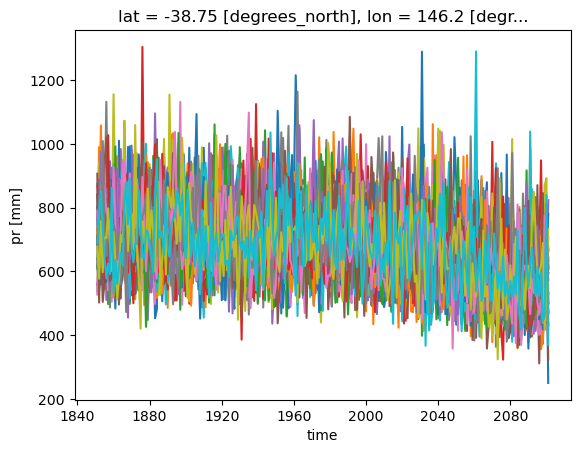

In [122]:
data_ds.sel(lat=-39, lon=145, method='nearest').plot(**plot_kwargs);

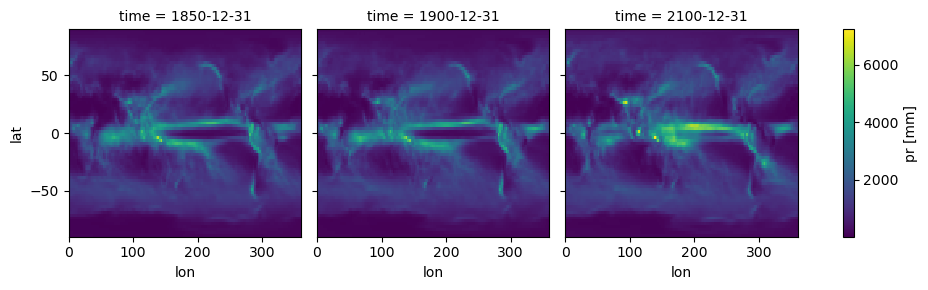

In [123]:
data_ds.isel(time=[0, 50, -1], **member_kwargs).plot(col='time')

In [124]:
data_ds

<xarray.DataArray 'pr' (member: 40, time: 251, lat: 72, lon: 144)> Size: 833MB
dask.array<chunksize=(1, 251, 6, 12), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (1)

<h2 style='color: cyan'> ERA5 Resample (large data) </h2>

In [125]:
# MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
# output_file = Path(os.path.join(MY_ERA5_PATH, f"{variable}.zarr"))
# output_file

In [126]:
# data_ds = xr.open_zarr(str(output_file), chunks=CHUNKS_FOR_ERA5)[variable]#.to_array()
# data_ds = data_ds.fillna(0)

In [57]:
# data_ds

In [58]:
# data_ds = data_ds.isel(time=slice(None, -1))

<h2 style='color:cyan'> Data Check </h2>

In [21]:
data_ds = data_ds.transpose(..., "time").chunk(chunks).persist()
wait(data_ds);

In [22]:
# Remove data that occurs before this
data_ds = data_ds.sel(time=data_ds.time.dt.year>=base_period.start)
data_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 145)> Size: 38MB
dask.array<getitem, shape=(180, 360, 145), dtype=float32, chunksize=(18, 36, 145), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1880-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (6)

In [23]:
chunks

{'time': -1, 'lat': 18, 'lon': 36}

In [24]:
# Make sure chunks is 1
assert len(data_ds.chunksizes['time']) == 1

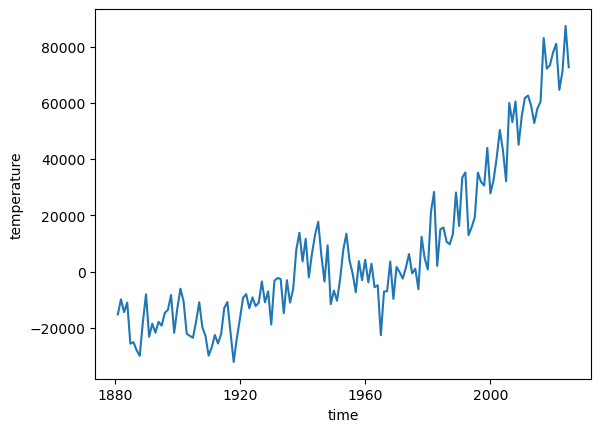

In [25]:
# data_ds.mean(dim=['lat', 'lon']).plot()
data_ds.sum(dim=['lat', 'lon']).plot()

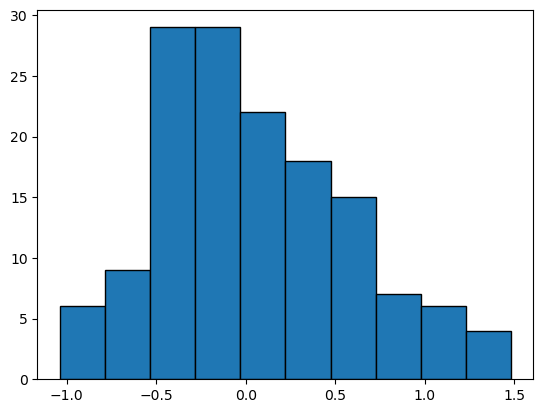

In [26]:
plt.hist(data_ds.sel(lat=-38, lon=145, method='nearest').squeeze().values, edgecolor='k');

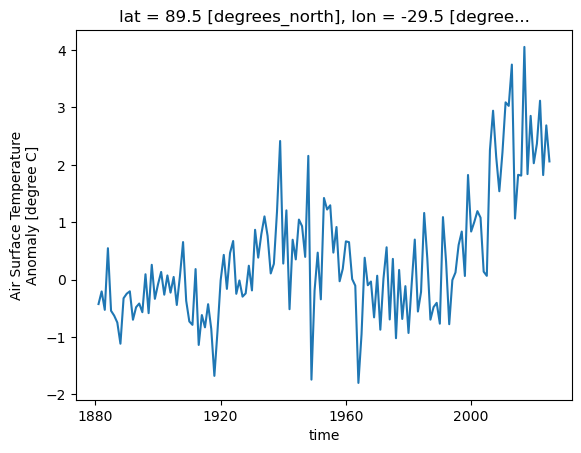

In [27]:
data_ds.sel(lat=89.5, lon=-29.75, method='nearest').plot()

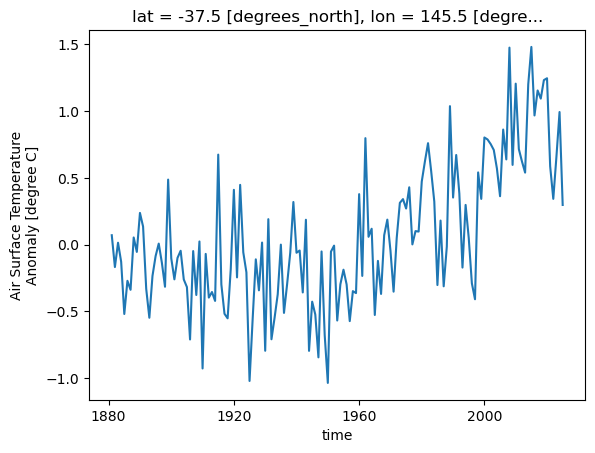

In [28]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot(**plot_kwargs);

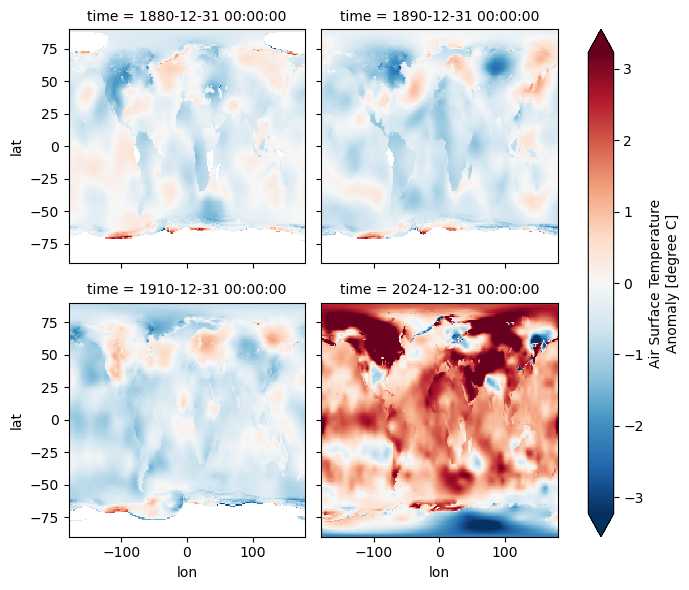

In [29]:
data_ds.isel(time=[0, 10, 30, -1], **member_kwargs).plot(col='time', col_wrap=2, robust=True)

In [30]:
# Calculate statistics
min_val = data_ds.min().values.item()
q25_val = data_ds.reduce(np.nanpercentile, q=25).values.item()
q75_val = data_ds.reduce(np.nanpercentile, q=75).values.item()
max_val = data_ds.max().values.item()

# Display nicely
print(f"Statistics:\n"
      f"Min: {min_val:.2f}\n"
      f"25th Percentile: {q25_val:.2f}\n"
      f"75th Percentile: {q75_val:.2f}\n"
      f"Max: {max_val:.2f}")

Statistics:
Min: -7.22
25th Percentile: -0.35
75th Percentile: 0.49
Max: 23.40


In [31]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(145,
 array([cftime.DatetimeGregorian(1880, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(1881, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(1882, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2022, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2023, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2024, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
       dtype=object))

In [32]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(145,
 array([cftime.DatetimeGregorian(1880, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(1881, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(1882, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2022, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2023, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2024, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
       dtype=object))

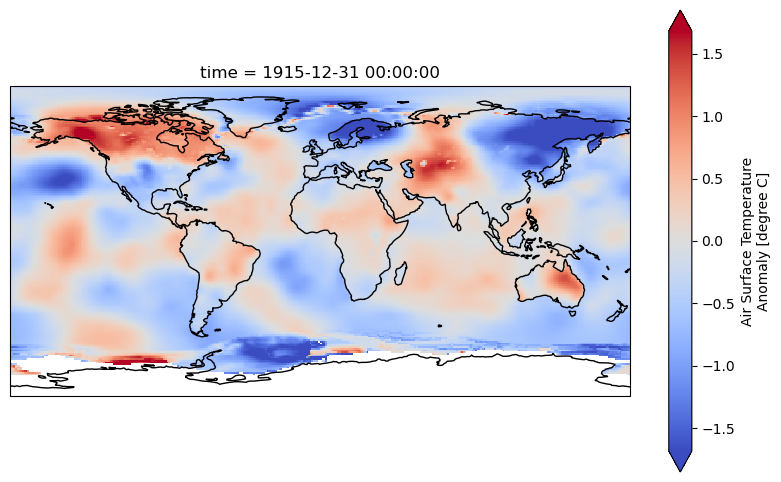

In [33]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=35, **member_kwargs).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [34]:
base_period_ds = data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
base_period_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 30)> Size: 8MB
dask.array<getitem, shape=(180, 360, 30), dtype=float32, chunksize=(18, 36, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 240B 1880-12-31 00:00:00 ... 1909-12-31 00:00:00
Attributes: (6)

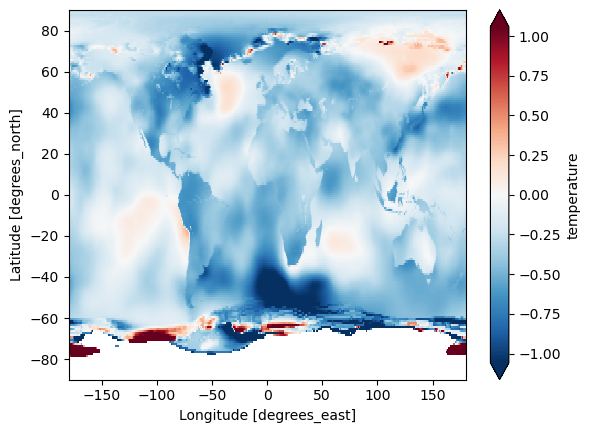

In [35]:
base_period_ds.mean(dim='time').isel(**member_kwargs).plot(robust=True)

In [36]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
# How many years are needed for 80 percent
percent_80_of_years = 0.8*(base_period.end - base_period.start)
data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)> Size: 518kB
dask.array<where, shape=(180, 360), dtype=int64, chunksize=(18, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

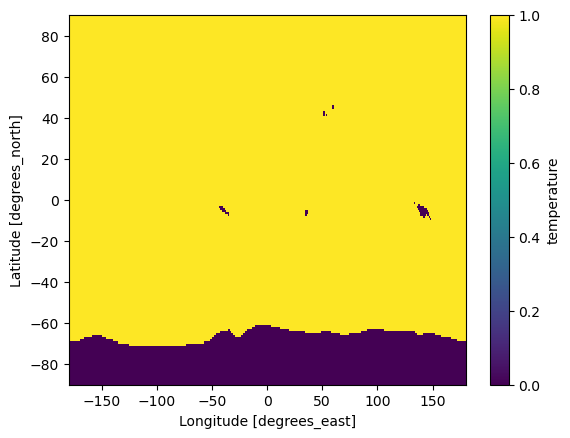

In [37]:
data_availability_mask.isel(**member_kwargs).plot()

In [38]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [39]:
# Resetting the anomlies to 1850
data_anom_ds = data_ds - base_period_ds.mean(dim='time')
base_period_anom_ds = base_period_ds - base_period_ds.mean(dim='time')

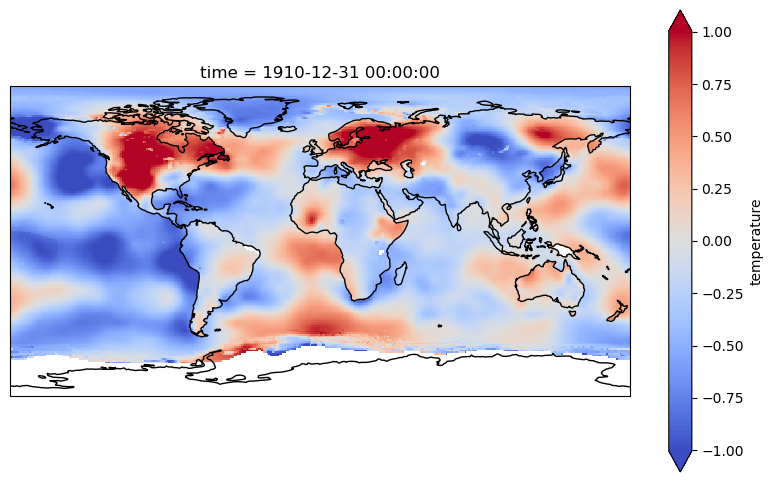

In [40]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_anom_ds.isel(time=30, **member_kwargs).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

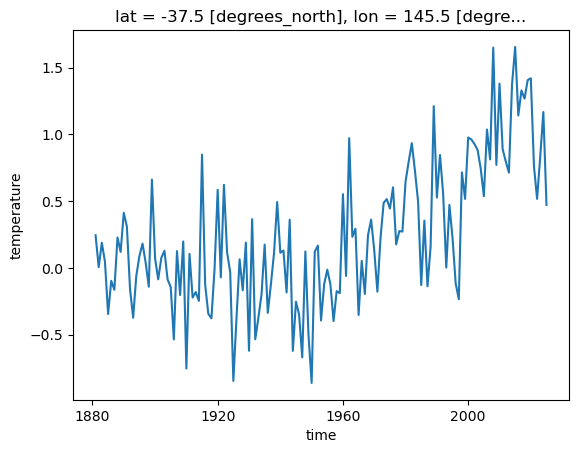

In [41]:
data_anom_ds.sel(lat=-38, lon=145, method='nearest').plot(**plot_kwargs);

In [42]:
data_ds.sel(lat=-38, lon=145, method='nearest').values

array([ 0.07, -0.17,  0.01, -0.13, -0.52, -0.27, -0.34,  0.05, -0.06,
        0.24,  0.13, -0.33, -0.55, -0.24, -0.09,  0.01, -0.14, -0.32,
        0.49, -0.1 , -0.26, -0.1 , -0.05, -0.26, -0.32, -0.71, -0.05,
       -0.38,  0.02, -0.93, -0.07, -0.4 , -0.36, -0.42,  0.67, -0.3 ,
       -0.52, -0.55, -0.18,  0.41, -0.25,  0.45, -0.06, -0.21, -1.02,
       -0.56, -0.11, -0.34,  0.01, -0.8 ,  0.19, -0.71, -0.55, -0.37,
       -0.  , -0.51, -0.3 , -0.06,  0.32, -0.06, -0.04, -0.36,  0.19,
       -0.8 , -0.43, -0.52, -0.85, -0.05, -0.68, -1.04, -0.05, -0.01,
       -0.57, -0.3 , -0.19, -0.3 , -0.57, -0.35, -0.36,  0.38, -0.24,
        0.8 ,  0.06,  0.12, -0.53, -0.12, -0.37,  0.07,  0.19, -0.04,
       -0.35,  0.05,  0.31,  0.34,  0.27,  0.43,  0.  ,  0.1 ,  0.1 ,
        0.47,  0.62,  0.76,  0.55,  0.32, -0.3 ,  0.18, -0.31, -0.01,
        1.04,  0.35,  0.67,  0.38, -0.17,  0.3 ,  0.05, -0.29, -0.41,
        0.54,  0.34,  0.8 ,  0.79,  0.75,  0.71,  0.57,  0.36,  0.86,
        0.64,  1.48,

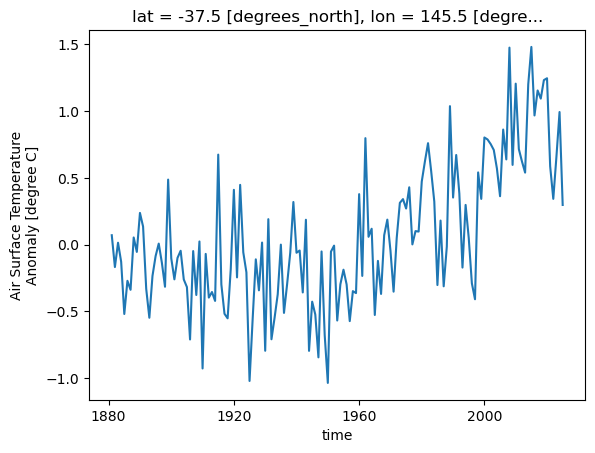

In [43]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot(**plot_kwargs);

<h1 style='color: yellow'> Metric Calculation </h1>

<h2 style='color: cyan'> New Hypothesis </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

### Functions

In [52]:
# def _block_resample(series, length, block_size, rng):
#     """
#     Resample a 1D series using block bootstrap.

#     Parameters
#     ----------
#     series : array_like
#         Input 1D array.
#     length : int
#         Target length of the resampled series.
#     block_size : int
#         Block length for resampling.
#     rng : np.random.Generator
#         Random number generator.

#     Returns
#     -------
#     resampled : ndarray
#         Resampled array of length `length`.
#     """
#     n_blocks = int(np.ceil(length / block_size))
#     starts = rng.integers(0, len(series) - block_size + 1, size=n_blocks)
#     return np.concatenate([series[s:s+block_size] for s in starts])[:length]


# def block_bootstrap_statistic(arr1, arr2, func, block_size=5, n_boot=500, rng=None):
#     """
#     Block bootstrap version of the two-sample KS test.
#     Uses the exact DP p-value inside ks_test.

#     Parameters
#     ----------
#     arr1, arr2 : array-like
#         Input samples. Must be the same length (n1 = n2).
#     block_size : int
#         Length of resampling blocks.
#     n_boot : int
#         Number of bootstrap replicates.
#     rng : int or np.random.Generator, optional
#         Random seed or Generator for reproducibility.

#     Returns
#     -------
#     stat_obs : float
#         Observed statistic.
#     pval : float
#         Bootstrap p-value: fraction of bootstrap replicates ≥ observed.
#     """
#     rng = np.random.default_rng(rng)
#     n1, n2 = len(arr1), len(arr2)
#     if n1 != n2:
#         raise ValueError("Exact KS test requires equal sample sizes")

#     # Observed statistic (with exact pval)
#     stat_obs = func(arr1, arr2)

#     # Bootstrap replicates
#     boot_stats = np.empty(n_boot)
#     combined = np.concatenate([arr1, arr2])

#     for i in range(n_boot):
#         x_star = _block_resample(combined, n1, block_size, rng)
#         y_star = _block_resample(combined, n2, block_size, rng)
#         boot_stats[i] = func(x_star, y_star)

#     pval = np.mean(boot_stats >= stat_obs)
    
#     return stat_obs, pval

In [44]:
from scipy.stats import t
import math
from scipy import stats
from numba import njit
from math import sqrt

In [45]:
# # P-value methods works better with a large cluster.
# # Small chunks with large computation
client.cluster.scale(100);
sleep(7);

 -         Start Nanny at: 'tcp://127.0.0.1:41135'
 -         Start Nanny at: 'tcp://127.0.0.1:36287'
 -         Start Nanny at: 'tcp://127.0.0.1:33863'
 -         Start Nanny at: 'tcp://127.0.0.1:40141'
 -         Start Nanny at: 'tcp://127.0.0.1:36171'
 -         Start Nanny at: 'tcp://127.0.0.1:40591'
 -         Start Nanny at: 'tcp://127.0.0.1:34495'
 -         Start Nanny at: 'tcp://127.0.0.1:33107'
 -         Start Nanny at: 'tcp://127.0.0.1:37671'
 -         Start Nanny at: 'tcp://127.0.0.1:34455'
 -         Start Nanny at: 'tcp://127.0.0.1:39345'
 -         Start Nanny at: 'tcp://127.0.0.1:35975'
 -         Start Nanny at: 'tcp://127.0.0.1:36173'
 -         Start Nanny at: 'tcp://127.0.0.1:37367'
 -         Start Nanny at: 'tcp://127.0.0.1:35871'
 -         Start Nanny at: 'tcp://127.0.0.1:33243'
 -         Start Nanny at: 'tcp://127.0.0.1:41005'
 -         Start Nanny at: 'tcp://127.0.0.1:36753'
 -         Start Nanny at: 'tcp://127.0.0.1:39167'
 -         Start Nanny at: 'tcp

In [46]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [47]:
class TTestLookup:
    def __init__(self, t_max=10.0, t_step=0.01, df_max=600):
        """
        Precompute a lookup table of two-sided p-values for Welch's t-test.

        Parameters
        ----------
        t_max : float
            Maximum t-statistic value to cover.
        t_step : float
            Step size for t-statistic grid.
        df_max : int
            Maximum degrees of freedom to cover.
        """
        (self.t_values,
         self.df_values,
         self.ttest_lookup) = self._build_ttest_lookup(t_max, t_step, df_max)

    # ---------------------------
    # Static builders
    # ---------------------------
    @staticmethod
    def _build_ttest_lookup(t_max, t_step, df_max):
        """
        Build grid + lookup for Welch's t-test (two-sided p-values).

        Parameters
        ----------
        t_max : float
            Maximum t-statistic to precompute.
        t_step : float
            Step size along t-axis.
        df_max : int
            Maximum degrees of freedom to precompute.

        Returns
        -------
        t_values : ndarray
            Grid of t-statistic values.
        df_values : ndarray
            Grid of degrees of freedom.
        lookup : 2D ndarray
            Precomputed p-values with shape (len(df_values), len(t_values)).
        """
        t_values = np.arange(0, t_max + t_step, t_step, dtype=np.float32)
        df_values = np.arange(2, df_max + 1, dtype=np.int32)

        df_grid, t_grid = np.meshgrid(df_values, t_values, indexing="ij")
        lookup = 2 * stats.t.sf(t_grid, df_grid).astype(np.float32)

        return t_values, df_values, lookup

    # ---------------------------
    # Static lookup helper
    # ---------------------------
    @staticmethod
    @njit
    def _lookup_t(t_value, df, t_values, df_values, lookup):
        """
        Query Welch’s t-test lookup table.

        Parameters
        ----------
        t_value : float
            Observed t-statistic.
        df : int
            Degrees of freedom.
        t_values, df_values : ndarray
            Grids of precomputed t and df values.
        lookup : ndarray
            Lookup table of p-values.

        Returns
        -------
        pval : float
            Approximated two-sided p-value.
        """
        t_value = abs(t_value)

        if t_value > t_values[-1]:
            return 0.0

        j = np.searchsorted(t_values, t_value)
        if j >= len(t_values):
            j = len(t_values) - 1
        i = np.searchsorted(df_values, df)
        if i >= len(df_values):
            i = len(df_values) - 1

        return lookup[i, j]

    # ---------------------------
    # Public API
    # ---------------------------
    def pval(self, t_value, df):
        """Return p-value for Welch’s t-test from lookup."""
        return self._lookup_t(t_value, df, self.t_values, self.df_values, self.ttest_lookup)


In [48]:
    # n1, n2 = len(arr1), len(arr2)
    # mean1, mean2 = arr1.mean(), arr2.mean()
    # var1, var2 = arr1.var(ddof=1), arr2.var(ddof=1)

    # # Standard error
    # se = np.sqrt(var1/n1 + var2/n2)

    # # Test statistic
    # t_stat = (mean1 - mean2) / se

In [225]:
@njit(inline='always')
def ttest_statistic(arr1, arr2):
    n1, n2 = len(arr1), len(arr2)

    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)

    # Numba only supports population variance, so compute sample variance manually
    var1 = np.sum((arr1 - mean1) ** 2) / (n1 - 1)
    var2 = np.sum((arr2 - mean2) ** 2) / (n2 - 1)

    se = np.sqrt(var1 / n1 + var2 / n2)
    t_stat = (mean1 - mean2) / se
    return t_stat

@njit
def ttest_statistic_and_deg_free(arr1, arr2):
    n1, n2 = len(arr1), len(arr2)

    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)

    # Numba only supports population variance, so compute sample variance manually
    var1 = np.sum((arr1 - mean1) ** 2) / (n1 - 1)
    var2 = np.sum((arr2 - mean2) ** 2) / (n2 - 1)

    se = np.sqrt(var1 / n1 + var2 / n2)
    t_stat = (mean1 - mean2) / se

    # Effective degrees of freedom (Satterthwaite approximation)
    deg_free = (var1/n1 + var2/n2)**2 / (
        (var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1)
    )
    
    return t_stat, deg_free


def welch_ttest(arr1, arr2, use_lookup=True):
    """
    Welch's t-test (robust to unequal variances).
    Optionally uses a precomputed lookup table for p-values.

    Parameters
    ----------
    arr1, arr2 : array_like
        Input 1D arrays of sample data.
    use_lookup : bool, optional
        If True, use a lookup table instead of scipy.stats.t.cdf.
    t_vals, df_vals, lookup : arrays, optional
        Precomputed t values, degrees of freedom values, and lookup table grid.
        Required if use_lookup=True.

    Returns
    -------
    t_stat : float
        Welch's t statistic.
    pval : float
        Two-sided p-value.
    """

    t_stat, deg_free = ttest_statistic_and_deg_free(arr1, arr2)



    if use_lookup:
        pval = ttest_lookup.pval(t_stat, deg_free)
    else:
        pval = 2 * stats.t.sf(abs(t_stat), deg_free)
        
    return t_stat, pval

def ks_statistic(arr1, arr2):
    """
    Compute the Kolmogorov–Smirnov (KS) statistic for two 1D samples.

    Parameters
    ----------
    arr1, arr2 : array-like
        Input samples.

    Returns
    -------
    d_stat : float
        The KS statistic, i.e. the maximum absolute difference
        between the two empirical cumulative distribution functions.
    """
    data1, data2 = np.sort(arr1), np.sort(arr2)
    n1, n2 = len(data1), len(data2)

    # Build empirical CDFs
    combined = np.concatenate([data1, data2])
    cdf1 = np.searchsorted(data1, combined, side="right") / n1
    cdf2 = np.searchsorted(data2, combined, side="right") / n2

    return np.max(np.abs(cdf1 - cdf2))


@njit(inline='always')
def ks_statistic_numba(data1, data2):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1, n2 = len(data1), len(data2)
    combined = np.empty(n1 + n2)
    combined[:n1] = data1
    combined[n1:] = data2
    combined.sort()

    d = 0.0
    j1 = j2 = 0
    for x in combined:
        while j1 < n1 and data1[j1] <= x:
            j1 += 1
        while j2 < n2 and data2[j2] <= x:
            j2 += 1
        cdf1 = j1 / n1
        cdf2 = j2 / n2
        diff = abs(cdf1 - cdf2)
        if diff > d:
            d = diff
    return d

def ks_test(arr1, arr2, n_terms=100):
    """
    Two-sample Kolmogorov–Smirnov test (asymptotic p-value).
    Uses the series expansion, which matches SciPy's outputs well at n~50,
    with a fix for the 0 vs 1 mismatch.
    """
    n1, n2 = len(arr1), len(arr2)

    # KS statistic
    d_stat = ks_statistic_numba(arr1, arr2)

    # Effective sample size
    n_eff = n1 * n2 / (n1 + n2)
    x = (np.sqrt(n_eff) + 0.12 + 0.11/np.sqrt(n_eff)) * d_stat

    # Asymptotic series expansion
    j = np.arange(1, n_terms+1)
    terms = (-1)**(j-1) * np.exp(-2 * (x**2) * (j**2))
    pval = 2 * np.sum(terms)

    # Clamp and handle under/overflow like SciPy
    if pval <= 0.0:
        pval = 1.0
    elif pval >= 1.0:
        pval = 0.0

    return d_stat, pval

In [226]:
def fast_mannwhitney(arr1, arr2, alternative="two-sided"):
    """
    Mann–Whitney U test (Wilcoxon rank-sum) using NumPy only.
    Asymptotic normal approximation for p-value.

    Parameters
    ----------
    arr1, arr2 : 1D arrays
        Input samples.
    alternative : {"two-sided", "less", "greater"}
        Alternative hypothesis.

    Returns
    -------
    u_stat : float
        Mann–Whitney U statistic (for arr1).
    pval : float
        p-value (approximate, large-sample normal).
    """
    n1, n2 = len(arr1), len(arr2)

    # rank all values together
    all_data = np.concatenate([arr1, arr2])
    ranks = np.empty_like(all_data, dtype=float)
    order = np.argsort(all_data)
    ranks[order] = np.arange(1, len(all_data)+1)

    # average ranks for ties
    _, inv, counts = np.unique(all_data[order], return_inverse=True, return_counts=True)
    tie_ranks = np.bincount(inv, weights=np.arange(1, len(all_data)+1)) / counts
    ranks[order] = tie_ranks[inv]

    # sum of ranks for arr1
    r1 = ranks[:n1].sum()

    # Mann–Whitney U statistic
    u1 = r1 - n1*(n1+1)/2
    u2 = n1*n2 - u1
    u_stat = min(u1, u2)

    # mean and variance under null
    mean_u = n1*n2 / 2
    tie_corr = (np.sum(counts**3 - counts) / (12*(n1+n2)*(n1+n2-1))) if np.any(counts > 1) else 0
    var_u = n1*n2*(n1+n2+1)/12 - n1*n2/(n1+n2)*(tie_corr*(n1+n2-1))
    sd_u = sqrt(var_u)

    # z-score with continuity correction
    z = (u_stat - mean_u + 0.5*np.sign(mean_u - u_stat)) / sd_u

    # p-value
    if alternative == "two-sided":
        pval = 2 * stats.norm.sf(abs(z))
    elif alternative == "greater":
        pval = stats.norm.sf(z)
    elif alternative == "less":
        pval = stats.norm.cdf(z)
    else:
        raise ValueError("alternative must be 'two-sided', 'less', or 'greater'")

    return u_stat, pval


In [227]:
def remove_nans(arr1, arr2):
    return arr1[np.isfinite(arr1)], arr2[np.isfinite(arr2)]

In [228]:
import numpy as np
from numba import njit

# --- Numba kernels ---

@njit(inline='always')
def _block_resample_numba(series, starts, block_size, length):
    """
    Numba-friendly block resampling.
    Takes a 1D array and start indices, and stitches blocks together.
    """
    resampled = np.empty(length, dtype=series.dtype)
    pos = 0
    for s in starts:
        for j in range(block_size):
            if pos >= length:
                break
            resampled[pos] = series[s + j]
            pos += 1
    return resampled


@njit
def _bootstrap_loop(arr1, arr2, combined, func, block_size, n_boot, starts_x, starts_y):
    """
    Inner bootstrap loop, compiled with Numba.
    """
    n1, n2 = len(arr1), len(arr2)
    boot_stats = np.empty(n_boot)

    for i in range(n_boot):
        x_star = _block_resample_numba(combined, starts_x[i], block_size, n1)
        y_star = _block_resample_numba(combined, starts_y[i], block_size, n2)
        boot_stats[i] = func(x_star, y_star)

    return boot_stats


def block_bootstrap_statistic(arr1, arr2, func, block_size=5, n_boot=500, rng=None):
    """
    Block bootstrap version of a two-sample statistic.

    Parameters
    ----------
    arr1, arr2 : array-like
        Input samples. Must be the same length (n1 = n2).
    func : callable
        Numba-compiled test statistic function.
    block_size : int
        Length of resampling blocks.
    n_boot : int
        Number of bootstrap replicates.
    rng : int or np.random.Generator, optional
        Random seed or Generator for reproducibility.

    Returns
    -------
    stat_obs : float
        Observed statistic.
    pval : float
        Bootstrap p-value: fraction of bootstrap replicates ≥ observed.
    """
    rng = np.random.default_rng(rng)
    n1, n2 = len(arr1), len(arr2)
    if n1 != n2:
        raise ValueError("Exact test requires equal sample sizes")

    # Observed statistic
    stat_obs = func(arr1, arr2)

    combined = np.concatenate([arr1, arr2])

    # Pre-generate block starts for each bootstrap
    # Number of blocks will be the length divided by the block_size
    n_blocks_x = int(np.ceil(n1 / block_size))
    n_blocks_y = int(np.ceil(n2 / block_size))

    # Shape will be a square matrix. 
    starts_x = rng.integers(0, len(combined) - block_size + 1, size=(n_boot, n_blocks_x))
    starts_y = rng.integers(0, len(combined) - block_size + 1, size=(n_boot, n_blocks_y))

    # Call Numba core
    boot_stats = _bootstrap_loop(arr1, arr2, combined, func, block_size, n_boot, starts_x, starts_y)

    # Bootstrap p-value
    pval = np.mean(boot_stats >= stat_obs)
    return stat_obs, pval


In [229]:
def fdr_bh_thresh_numpy(pvals, alpha=0.05):
    """
    Benjamini–Hochberg FDR correction for 1D array of p-values.
    Returns the threshold value only.
    """
    pvals = np.ravel(pvals)
    n = len(pvals)
    sort_idx = np.argsort(pvals)
    sorted_p = pvals[sort_idx]

    thresholds = alpha * (np.arange(1, n+1) / n)
    below = sorted_p <= thresholds
    if not np.any(below):
        return 0.0

    k = np.max(np.where(below)[0])
    return sorted_p[k]


def fdr_bh_thresh_xr(da, alpha=0.05, space_dims=("lat", "lon")):
    """
    Benjamini–Hochberg FDR threshold across spatial dimensions,
    applied independently for each time step.

    Parameters
    ----------
    da : xr.DataArray
        P-values with dims including time + space.
    alpha : float
        FDR control level.
    space_dims : tuple of str
        Dimensions to apply FDR across (default: ("lat","lon")).

    Returns
    -------
    pval_thresh : xr.DataArray (float)
        Threshold p-value at each time step, shape (time,).
    """
    thresh = xr.apply_ufunc(
        fdr_bh_thresh_numpy,
        da,
        alpha,
        input_core_dims=[list(space_dims), []],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )
    return thresh


In [230]:

def run_windowed_test(stat_func, base_period, window, data_ds=None, data_ds_window=None, base_period_window_ds=None):
    """
    Run hypothesis test between rolling future and rolling base-period windows.

    Parameters
    ----------
    stat_func : function
        Hypothesis test with signature (arr1, arr2, **kwargs) -> (stat, pval).
    data_ds : xr.DataArray
        Input time series dataset with dimension 'time'.
    base_period : slice
        Base period as a slice, e.g. slice('1850', '1900').
    win : int
        Rolling window length.

    Returns
    -------
    xr.Dataset with stat and pval
    """
    # When you apply .rolling(time=window, ...), xarray creates a rolling view:
    #   - At each time point, it knows about the "window" of neighbouring values,
    #     but these values are not yet exposed as a real dimension.
    #
    # .construct('window_dim') turns those hidden windows into an explicit new axis:
    #   - Your data shape goes from (time, ...) → (time, window_dim, ...).
    #   - For each center time, you now have the full set of values in that window
    #     stored along the new "window_dim".
    #
    # This is essential for later statistical comparisons:
    #   - By renaming the base period's 'time' dimension → 'window_dim',
    #     the reference years and the rolling windows now share the same axis name.
    #   - That way, xarray can align them and apply vectorised tests across all windows.
    #
    # Without .construct('window_dim'), you would only have a rolling object,
    # not an explicit dimension you can broadcast or align with other datasets.

    if data_ds_window is None:
        data_ds_window = (data_ds
                          .rolling(time=window, center=True, min_periods=window)
                          .construct('window_dim')
                          .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                          .persist()
                         ) 
        wait(data_ds_window);


    if base_period_window_ds is None:
        base_period_window_ds = (data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
                                 .chunk(CHUNKS_FOR_PVALUE_TESTS)
                                 .rename({'time':'window_dim'})
                                 .persist()
                                )
        wait(base_period_window_ds);
    
    rolling_window_kwargs = dict(
        input_core_dims=[["window_dim"], ["window_dim"]],
        exclude_dims={"window_dim"},
        dask="parallelized",
        vectorize=True,
        output_dtypes=[float, float], 
        output_core_dims=[[], []])

    stat, pval = xr.apply_ufunc(
        stat_func,
        data_ds_window,
        base_period_window_ds,
        **rolling_window_kwargs
    )

    stat_pval_ds =  xr.Dataset({"stat": stat, "pval": pval})

    stat_pval_ds = stat_pval_ds.persist()
    wait(stat_pval_ds);
    return stat_pval_ds

In [232]:
block_bootstrap_ks = partial(block_bootstrap_statistic, func=ks_statistic_numba)
block_bootstrap_ttest = partial(block_bootstrap_statistic, func=ttest_statistic)

### Function tests

In [53]:
samp_data = data_ds.sel(lat=-39, lon=145, method='nearest')
arr1 = samp_data.values[:30]
arr2 = samp_data.values[90:90+30]

In [65]:
n1 = len(arr1)
block_size = 5

In [66]:
n_blocks_x = int(np.ceil(n1 / block_size))

In [69]:
combined = np.concatenate([arr1, arr2])

In [125]:
rng = np.random.default_rng(None)
starts_x = rng.integers(0, len(combined) - block_size + 1, size=(n_blocks_x))

In [126]:
starts_x

array([12, 33, 46, 26, 12, 32])

In [129]:
x_star = _block_resample_numba(combined, starts_x, block_size, n1)

In [130]:
len(x_star), len(arr1)

(30, 30)

In [134]:
x_star_list = []
for i in range(10):
    starts_x = rng.integers(0, len(combined) - block_size + 1, size=(n_blocks_x))
    x_star = _block_resample_numba(combined, starts_x, block_size, n1)
    x_star_list.append(x_star)

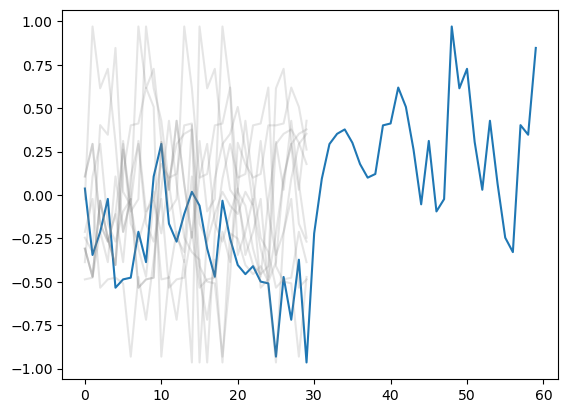

In [135]:
plt.plot(combined)
# plt.plot(x_star)
for xs in x_star_list:
    plt.plot(xs, color='grey', alpha=0.2)

In [136]:
# Observed statistic (with exact pval)
d_obs, _ = ks_test(arr1, arr2)
d_obs

0.7

In [137]:
n1, n2 = len(arr1), len(arr2)

In [140]:
_block_resample_numba?

Signature:       _block_resample_numba(series, starts, block_size, length)
Call signature:  _block_resample_numba(*args, **kwargs)
Type:            CPUDispatcher
String form:     CPUDispatcher(<function _block_resample_numba at 0x154c68fcf880>)
File:            /jobfs/151189715.gadi-pbs/ipykernel_2426723/620471895.py
Docstring:      
Numba-friendly block resampling.
Takes a 1D array and start indices, and stitches blocks together.
Class docstring:
Implementation of user-facing dispatcher objects (i.e. created using
the @jit decorator).
This is an abstract base class. Subclasses should define the targetdescr
class attribute.
Init docstring: 
Parameters
----------
py_func: function object to be compiled
locals: dict, optional
    Mapping of local variable names to Numba types.  Used to override
    the types deduced by the type inference engine.
targetoptions: dict, optional
    Target-specific config options.
pipeline_class: type numba.compiler.CompilerBase
    The compiler pipeline typ

In [148]:
from scipy.stats import ttest_ind, ks_2samp, mannwhitneyu

In [154]:
n_boot = 200
block_size = 5
boot_stats = np.empty(n_boot)
boot_stats_numba = np.empty(n_boot)
boot_stats_scipy = np.empty(n_boot)


combined = np.concatenate([arr1, arr2])

for i in range(n_boot):
    starts_x = rng.integers(0, len(combined) - block_size + 1, size=(n_blocks_x))
    starts_y = rng.integers(0, len(combined) - block_size + 1, size=(n_blocks_x))
    
    x_star = _block_resample_numba(combined, starts_x, block_size, n1)
    y_star = _block_resample_numba(combined, starts_y, block_size, n2)
    
    boot_stats[i] = ks_statistic(x_star, y_star)
    boot_stats_numba[i] = ks_statistic_numba(x_star, y_star)
    boot_stats_scipy[i] = ks_2samp(x_star, y_star).statistic

In [155]:
boot_stats_numba - boot_stats_scipy

array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,
        0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0

In [156]:
%%timeit
ks_statistic(x_star, y_star)

18.3 μs ± 143 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [157]:
%%timeit
ks_statistic_numba(x_star, y_star)

2.17 μs ± 14.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [158]:
pval = np.mean(boot_stats >= d_obs)
pval

0.005

In [159]:
ks_test(arr1, arr2)

(0.7, 2.619895662433618e-07)

In [161]:
ttest_lookup = TTestLookup(t_max=10.0, t_step=0.01, df_max=600)

In [162]:
# --- Simple tests ---
print("Case 1:", "lookup =", ttest_lookup.pval(0.5, 5),
      "direct =", 2 * stats.t.sf(abs(0.5), 5))

print("Case 2:", "lookup =", ttest_lookup.pval(2.5, 10),
      "direct =", 2 * stats.t.sf(abs(2.5), 10))

print("Case 3:", "lookup =", ttest_lookup.pval(5.0, 50),
      "direct =", 2 * stats.t.sf(abs(5.0), 50))

print("Case 4:", "lookup =", ttest_lookup.pval(7.5, 100),
      "direct =", 2 * stats.t.sf(abs(7.5), 100))

print("Case 5:", "lookup =", ttest_lookup.pval(10.0, 300),
      "direct =", 2 * stats.t.sf(abs(10.0), 300))

Case 1: lookup = 0.6382988691329956 direct = 0.638298871640929
Case 2: lookup = 0.03144684433937073 direct = 0.031446844236608776
Case 3: lookup = 7.433212431351421e-06 direct = 7.433212247232564e-06
Case 4: lookup = 2.6572398795221552e-11 direct = 2.657239926372068e-11
Case 5: lookup = 1.6558627517882952e-20 direct = 1.6558627351112513e-20


In [163]:
ttest_lookup.pval(0.5, 5)

0.6382988691329956

In [164]:
%%timeit
ttest_lookup.pval(0.5, 5)

368 ns ± 8.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [165]:
%%timeit
stats.t.sf(abs(0.5), 5)

48.5 μs ± 265 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [166]:
# ---------------------------
# Demo with toy arrays
# ---------------------------
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 3, 4, 5, 6])

print("Welch t-test:", welch_ttest(x, y))
print("KS test:", ks_test(x, y))
# print("Block bootstrap t-test:", block_bootstrap_ttest(x, y, block_size=2, n_boot=200, rng=0))
# print("Block bootstrap KS test:", block_bootstrap_ks(x, y, block_size=2, n_boot=200, rng=0))

Welch t-test: (-1.0, 0.3465934991836548)
KS test: (0.20000000000000007, 0.9996217060535831)


In [167]:

# --- Setup ---
rng = np.random.default_rng(0)
a = rng.normal(0, 1, 50)  # baseline sample

factors = [0.2, 0.5, 0.75, 1.0, 1.25, 2.0]
shifts  = [0.0, 0.2, 0.5, 1.0, 1.5, 2, 2.5]

# --- Variance change ---
fast_ttest_var = [welch_ttest(a, a * f)[-1] for f in factors]
scipy_ttest_var = [ttest_ind(a, a * f, equal_var=False).pvalue for f in factors]
np.testing.assert_allclose(fast_ttest_var, scipy_ttest_var, atol=0.01)

fast_ks_var = [ks_test(a, a * f)[-1] for f in factors]
scipy_ks_var = [ks_2samp(a, a * f).pvalue for f in factors]
np.testing.assert_allclose(fast_ks_var, scipy_ks_var, atol=0.05)

# --- Mean change ---
fast_ttest_mean = [welch_ttest(a, a + s)[-1] for s in shifts]
scipy_ttest_mean = [ttest_ind(a, a + s, equal_var=False).pvalue for s in shifts]
np.testing.assert_allclose(fast_ttest_mean, scipy_ttest_mean, atol=0.01)

fast_ks_mean = [ks_test(a, a + s)[-1] for s in shifts]
scipy_ks_mean = [ks_2samp(a, a + s).pvalue for s in shifts]
np.testing.assert_allclose(fast_ks_mean, scipy_ks_mean, atol=0.05)

# --- Mean + variance change ---
fast_ttest_both = [welch_ttest(a, (a * f) + s)[-1] for f, s in zip(factors, shifts*2)]
scipy_ttest_both = [ttest_ind(a, (a * f) + s, equal_var=False).pvalue for f, s in zip(factors, shifts*2)]
np.testing.assert_allclose(fast_ttest_both, scipy_ttest_both, atol=0.01)

fast_ks_both = [ks_test(a, (a * f) + s)[-1] for f, s in zip(factors, shifts*2)]
scipy_ks_both = [ks_2samp(a, (a * f) + s).pvalue for f, s in zip(factors, shifts*2)]
np.testing.assert_allclose(fast_ks_both, scipy_ks_both, atol=0.05)

In [172]:
# --- Mann–Whitney U tests ---
# Variance change
fast_mwu_var = [fast_mannwhitney(a, a * f)[-1] for f in factors]
scipy_mwu_var = [mannwhitneyu(a, a * f, alternative="two-sided").pvalue for f in factors]
np.testing.assert_allclose(fast_mwu_var, scipy_mwu_var, atol=0.05)

# Mean change
fast_mwu_mean = [fast_mannwhitney(a, a + s)[-1] for s in shifts]
scipy_mwu_mean = [mannwhitneyu(a, a + s, alternative="two-sided").pvalue for s in shifts]
np.testing.assert_allclose(fast_mwu_mean, scipy_mwu_mean, atol=0.05)

# Mean + variance change
fast_mwu_both = [fast_mannwhitney(a, (a * f) + s)[-1] for f, s in zip(factors, shifts*2)]
scipy_mwu_both = [mannwhitneyu(a, (a * f) + s, alternative="two-sided").pvalue for f, s in zip(factors, shifts*2)]
np.testing.assert_allclose(fast_mwu_both, scipy_mwu_both, atol=0.05)

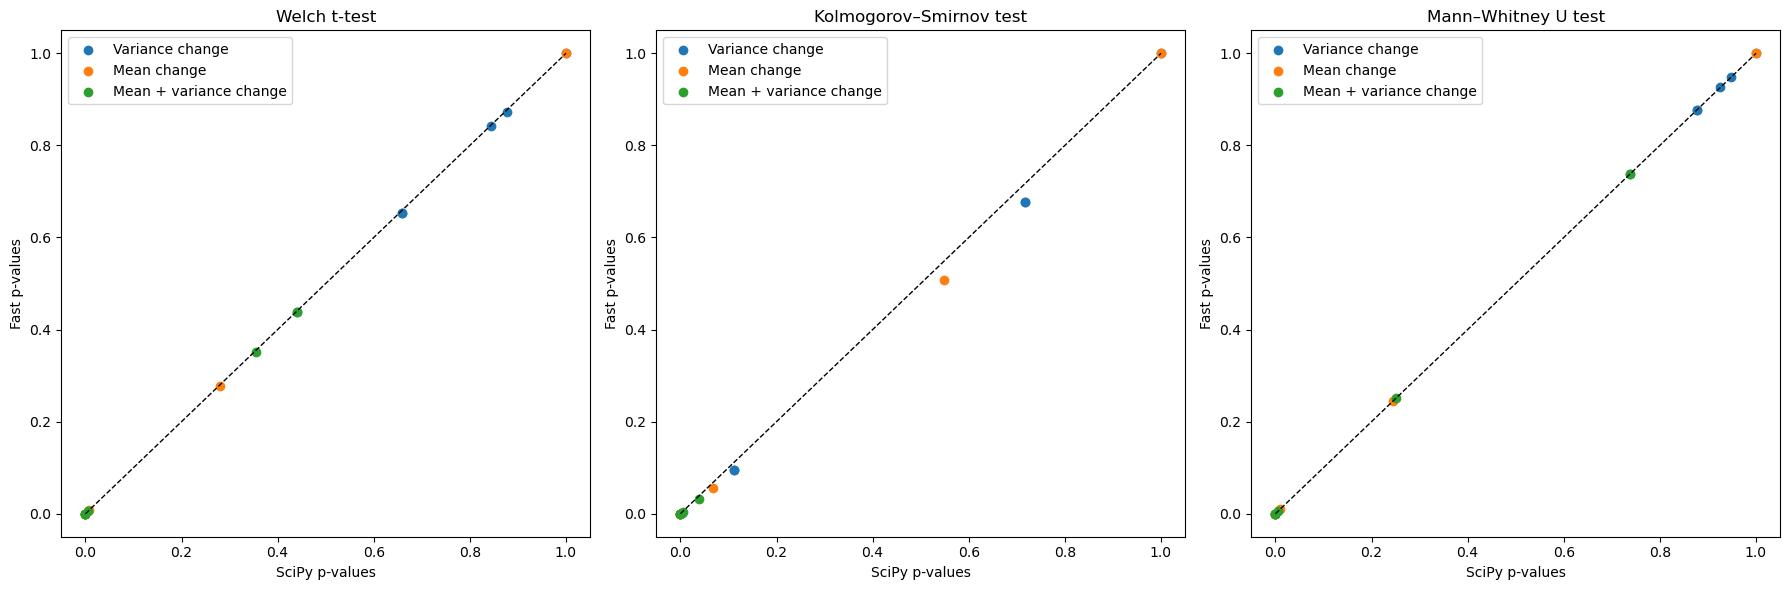

In [173]:
# --- Scatter plots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colours for each test type
colors = {"var": "tab:blue", "mean": "tab:orange", "both": "tab:green"}

# T-test scatter
axes[0].scatter(scipy_ttest_var, fast_ttest_var, c=colors["var"], label="Variance change")
axes[0].scatter(scipy_ttest_mean, fast_ttest_mean, c=colors["mean"], label="Mean change")
axes[0].scatter(scipy_ttest_both, fast_ttest_both, c=colors["both"], label="Mean + variance change")
axes[0].plot([0, 1], [0, 1], "k--", lw=1)
axes[0].set_xlabel("SciPy p-values")
axes[0].set_ylabel("Fast p-values")
axes[0].set_title("Welch t-test")
axes[0].legend()

# KS test scatter
axes[1].scatter(scipy_ks_var, fast_ks_var, c=colors["var"], label="Variance change")
axes[1].scatter(scipy_ks_mean, fast_ks_mean, c=colors["mean"], label="Mean change")
axes[1].scatter(scipy_ks_both, fast_ks_both, c=colors["both"], label="Mean + variance change")
axes[1].plot([0, 1], [0, 1], "k--", lw=1)
axes[1].set_xlabel("SciPy p-values")
axes[1].set_ylabel("Fast p-values")
axes[1].set_title("Kolmogorov–Smirnov test")
axes[1].legend()

# Mann–Whitney U test scatter
axes[2].scatter(scipy_mwu_var, fast_mwu_var, c=colors["var"], label="Variance change")
axes[2].scatter(scipy_mwu_mean, fast_mwu_mean, c=colors["mean"], label="Mean change")
axes[2].scatter(scipy_mwu_both, fast_mwu_both, c=colors["both"], label="Mean + variance change")
axes[2].plot([0, 1], [0, 1], "k--", lw=1)
axes[2].set_xlabel("SciPy p-values")
axes[2].set_ylabel("Fast p-values")
axes[2].set_title("Mann–Whitney U test")
axes[2].legend()

plt.tight_layout()



T-test (same distribution):
  Fast  -> stat = 1.0416, p = 0.2944
  SciPy -> stat = 1.0416, p = 0.2982

T-test (different mean):
  Fast  -> stat = -4.5474, p = 0.0000
  SciPy -> stat = -4.5474, p = 0.0000

KS test (same distribution):
  Fast  -> stat = 0.1050, p = 0.2078
  SciPy -> stat = 0.1050, p = 0.2205

KS test (different mean):
  Fast  -> stat = 0.1950, p = 0.0008
  SciPy -> stat = 0.1950, p = 0.0010

KS test (different shape):
  Fast  -> stat = 0.1350, p = 0.0475
  SciPy -> stat = 0.1350, p = 0.0521

Mann–Whitney U (same distribution):
  Fast  -> stat = 18398.0000, p = 0.1660
  SciPy -> stat = 21602.0000, p = 0.1660

Mann–Whitney U (different mean):
  Fast  -> stat = 15158.0000, p = 0.0000
  SciPy -> stat = 15158.0000, p = 0.0000

Mann–Whitney U (different shape):
  Fast  -> stat = 18694.0000, p = 0.2588
  SciPy -> stat = 18694.0000, p = 0.2588


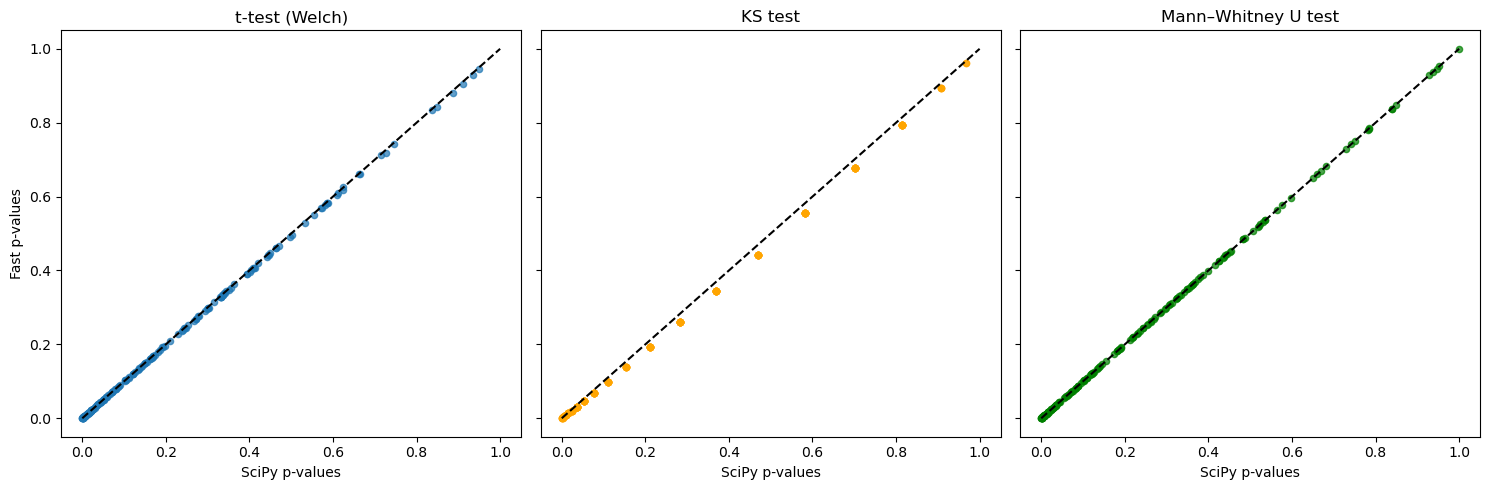

In [174]:
# ---------------------------
# Generate test data
# ---------------------------
rng = np.random.default_rng(0)

x1 = rng.normal(0, 1, 200)
x2 = rng.normal(0, 1, 200)       # same distribution
y1 = rng.normal(0, 1, 200)
y2 = rng.normal(0.5, 1, 200)     # different mean
z1 = rng.normal(0, 1, 200)
z2 = rng.laplace(0, 1, 200)      # different shape

# ---------------------------
# Print comparisons
# ---------------------------
def compare_ttests(a, b, name=""):
    stat_fast, p_fast = welch_ttest(a, b)
    res_scipy = ttest_ind(a, b, equal_var=False)  # Welch
    print(f"\nT-test ({name}):")
    print(f"  Fast  -> stat = {stat_fast:.4f}, p = {p_fast:.4f}")
    print(f"  SciPy -> stat = {res_scipy.statistic:.4f}, p = {res_scipy.pvalue:.4f}")

def compare_kstest(a, b, name=""):
    stat_fast, p_fast = ks_test(a, b)
    res_scipy = ks_2samp(a, b)
    print(f"\nKS test ({name}):")
    print(f"  Fast  -> stat = {stat_fast:.4f}, p = {p_fast:.4f}")
    print(f"  SciPy -> stat = {res_scipy.statistic:.4f}, p = {res_scipy.pvalue:.4f}")

def compare_mwu(a, b, name=""):
    stat_fast, p_fast = fast_mannwhitney(a, b)
    res_scipy = mannwhitneyu(a, b, alternative="two-sided")
    print(f"\nMann–Whitney U ({name}):")
    print(f"  Fast  -> stat = {stat_fast:.4f}, p = {p_fast:.4f}")
    print(f"  SciPy -> stat = {res_scipy.statistic:.4f}, p = {res_scipy.pvalue:.4f}")

# Run the comparisons
compare_ttests(x1, x2, name="same distribution")
compare_ttests(y1, y2, name="different mean")

compare_kstest(x1, x2, name="same distribution")
compare_kstest(y1, y2, name="different mean")
compare_kstest(z1, z2, name="different shape")

compare_mwu(x1, x2, name="same distribution")
compare_mwu(y1, y2, name="different mean")
compare_mwu(z1, z2, name="different shape")

# ---------------------------
# Visual: scatterplots fast vs SciPy p-values
# ---------------------------
vals = []
for i in range(200):
    a = rng.normal(0, 1, 100)
    b = rng.normal(0.2, 1, 100)

    _, pf_t = welch_ttest(a, b)
    ps_t = ttest_ind(a, b, equal_var=False).pvalue

    _, pf_k = ks_test(a, b)
    ps_k = ks_2samp(a, b).pvalue

    _, pf_m = fast_mannwhitney(a, b)
    ps_m = mannwhitneyu(a, b, alternative="two-sided").pvalue

    vals.append((pf_t, ps_t, pf_k, ps_k, pf_m, ps_m))

vals = np.array(vals)

fig, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

# Welch t-test
axes[0].scatter(vals[:,1], vals[:,0], s=20, alpha=0.7)
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_title("t-test (Welch)")
axes[0].set_xlabel("SciPy p-values")
axes[0].set_ylabel("Fast p-values")

# KS test
axes[1].scatter(vals[:,3], vals[:,2], s=20, alpha=0.7, color="orange")
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_title("KS test")
axes[1].set_xlabel("SciPy p-values")

# Mann–Whitney U test
axes[2].scatter(vals[:,5], vals[:,4], s=20, alpha=0.7, color="green")
axes[2].plot([0,1],[0,1],'k--')
axes[2].set_title("Mann–Whitney U test")
axes[2].set_xlabel("SciPy p-values")

plt.tight_layout()
plt.show()


In [104]:
samp_data = data_ds.sel(lat=-39, lon=145, method='nearest')
arr1 = samp_data.values[:30]
arr2 = samp_data.values[90:90+30]

In [105]:
bbs_ks_pval = block_bootstrap_ks(arr1, arr2)

In [108]:
scipy_ks = ks_2samp(arr1, arr2)

In [82]:
ks_pval = ks_test(arr1, arr2)

In [109]:
bbs_ks_pval, ks_pval, scipy_ks

((0.7, 0.796),
 (0.7, 2.619895662433618e-07),
 KstestResult(statistic=0.7, pvalue=2.5000118318420276e-07, statistic_location=0.01835814, statistic_sign=1))

In [118]:
reload(toe_calc)

<module 'toe_calc' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py'>

In [200]:
def stats_test_1d_array(arr, stats_func, window: int=20, base_period_length:int = 50):
    """
    Apply stats_func test along a 1D array.

    Parameters:
        arr (ArrayLike): 1D array to apply the test to.
        window (int): Size of the rolling window for the test.
        base_period_length (int, optional): Length of the base period. Defaults to 50.

    Returns:
        ArrayLike: Array of p-values.
    """
    # The data to use for the base period
    base_list = arr[:base_period_length]
    # Stop when there are not enough points left
    number_iterations = arr.shape[0] - window
    pval_array = []
    
    for t in np.arange(number_iterations):
        arr_subset = arr[t: t+window]
        p_value = stats_func(base_list, arr_subset)
        pval_array.append(p_value)

    return pval_array 


In [201]:
samp_data = data_ds.sel(lat=-39, lon=145, method='nearest')
arr1 = samp_data.values[:30]
arr2 = samp_data.values[90:90+30]

In [202]:
%%time
ks_fast_1ds = stats_test_1d_array(samp_data.values, ks_test, window=30, base_period_length=30)

CPU times: user 503 ms, sys: 81.4 ms, total: 584 ms
Wall time: 447 ms


In [203]:
%%time
ks_1ds = stats_test_1d_array(samp_data.values, ks_2samp, window=30, base_period_length=30)

CPU times: user 139 ms, sys: 26.8 ms, total: 166 ms
Wall time: 157 ms


In [204]:
%%time
ks_bbs_1ds = stats_test_1d_array(samp_data.values, block_bootstrap_ks, window=30, base_period_length=30)

CPU times: user 936 ms, sys: 149 ms, total: 1.09 s
Wall time: 857 ms


In [214]:
ks_fast_1ds_stat = np.array(list(map(lambda x:x[0], ks_fast_1ds)))
ks_fast_1ds_pval = np.array(list(map(lambda x:x[1], ks_fast_1ds)))

In [215]:
ks_bbs_1ds_stat = np.array(list(map(lambda x:x[0], ks_bbs_1ds)))
ks_bbs_1ds_pval = np.array(list(map(lambda x:x[1], ks_bbs_1ds)))

In [216]:
ks_1ds_stat = np.array(list(map(lambda x:x.statistic, ks_1ds)))
ks_1ds_pval = np.array(list(map(lambda x:x.pvalue, ks_1ds)))

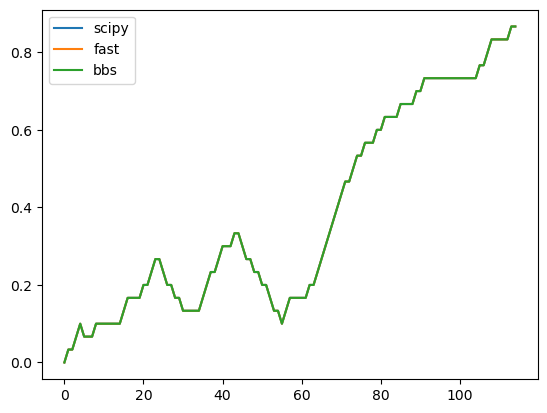

In [221]:
plt.plot(ks_1ds_stat, label='scipy')
plt.plot(ks_fast_1ds_stat, label='fast')
plt.plot(ks_bbs_1ds_stat, label='bbs')
plt.legend()

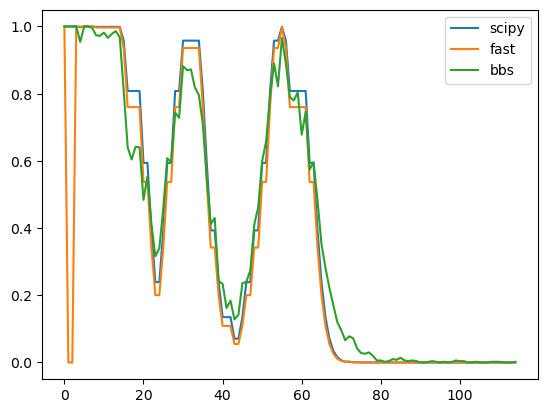

In [213]:
plt.plot(ks_1ds_pval, label='scipy')
plt.plot(ks_fast_1ds_pval, label='fast')
plt.plot(ks_bbs_1ds_pval, label='bbs')
plt.legend()

### Running

In [176]:
window = 30
CHUNKS_FOR_PVALUE_TESTS = chunks

In [177]:
data_ds_window = (data_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [178]:
wait(data_ds_window);
wait(base_period_window_ds);

In [179]:
# ks_test, fast_mannwhitney, block_bootstrap_ks, block_bootstrap_ttest

In [180]:
%%time
welch_ttest_ds = run_windowed_test(
    welch_ttest, base_period, window=30,
    data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds).compute()

CPU times: user 3.2 s, sys: 1.14 s, total: 4.34 s
Wall time: 5.75 s


In [181]:
%%time
ks_ds = run_windowed_test(ks_test, base_period, window=30,
    data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds).compute()

CPU times: user 2.71 s, sys: 1.17 s, total: 3.88 s
Wall time: 5.51 s


In [182]:
%%time
mwu_ds = run_windowed_test(fast_mannwhitney, base_period, window=30,
    data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds).compute()

CPU times: user 4.96 s, sys: 2.41 s, total: 7.37 s
Wall time: 11.8 s


In [233]:
%%time
ks_bbs_ds = run_windowed_test(
    block_bootstrap_ks, base_period, window=30,
    data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds)
ks_bbs_ds = ks_bbs_ds.compute()

CPU times: user 1min 27s, sys: 38.9 s, total: 2min 6s
Wall time: 3min 59s


In [234]:
%%time
ttest_bbs_ds = run_windowed_test(
    block_bootstrap_ttest, base_period, window=30,
    data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds)
ttest_bbs_ds = ttest_bbs_ds.compute()

CPU times: user 8.27 s, sys: 4.13 s, total: 12.4 s
Wall time: 21.8 s


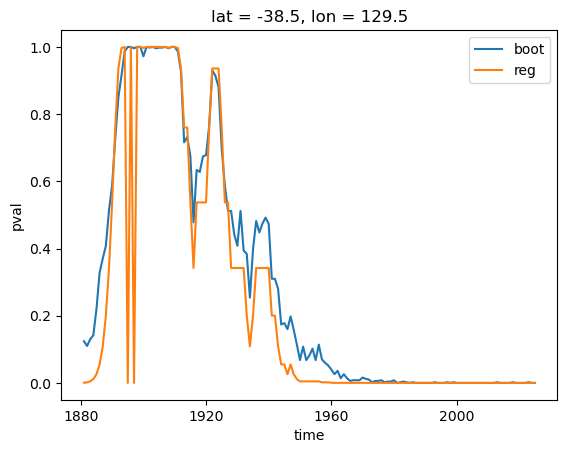

In [242]:
ks_bbs_ds.sel(lat=-38.5, lon=129.5, method='nearest').pval.plot(label='boot')
ks_ds.sel(lat=-38.5, lon=129.5, method='nearest').pval.plot(label='reg')
plt.legend()

In [243]:
windows = [10, 15, 20, 25, 30, 40, 50, 80, 100, 150]

In [269]:
def run_over_windows(test_func, data_ds, windows, base_period):
    """
    Run a statistical test over multiple window sizes and merge results.

    Parameters
    ----------
    test_func : callable
        Test function to use inside run_windowed_test (e.g., ks_test).
    windows : list[int]
        List of window sizes to test.
    base_period : slice or object
        Base period for the test.
    data_ds : xr.Dataset
        Input dataset to apply the tests on.

    Returns
    -------
    xr.Dataset
        Merged dataset with test results for all windows.
    """
    window_list = []
    for window in windows:
        print(f'{window}, ', end='')
        window_ds = run_windowed_test(
            test_func, base_period, window=window, data_ds=data_ds
        ).compute()
        window_ds = window_ds.expand_dims(window=[window])
        window_list.append(window_ds)

    return xr.concat(window_list, dim='window')


In [ ]:
ks_windows_ds = run_over_windows(ks_test, data_ds, windows, base_period)

10, 15, 20, 

In [278]:
ttest_windows_ds = run_over_windows(welch_ttest, data_ds, windows, base_period)

10, 15, 20, 25, 30, 40, 50, 80, 100, 150, 

In [272]:
ks_windows_ds

<xarray.Dataset> Size: 2GB
Dimensions:  (window: 10, lat: 180, lon: 360, time: 145)
Coordinates:
  * window   (window) int64 80B 10 15 20 25 30 40 50 80 100 150
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1880-12-31 00:00:00 ... 2024-12-31 00:00:00
Data variables:
    stat     (window, lat, lon, time) float64 752MB 0.0 0.0 0.0 ... 0.72 0.7267
    pval     (window, lat, lon, time) float64 752MB 1.0 1.0 ... 1.493e-12

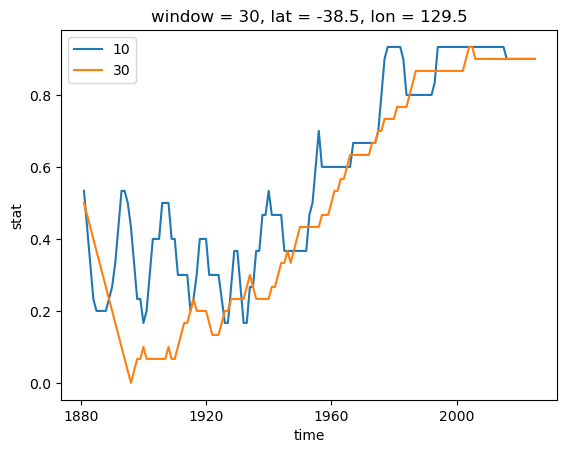

In [276]:
ks_windows_ds.sel(window=10).stat.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10')
ks_windows_ds.sel(window=30).stat.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='30')
plt.legend()

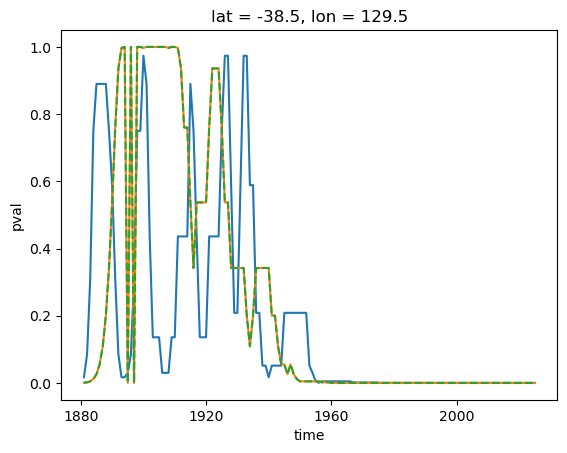

In [274]:
ks_windows_ds.sel(window=10).pval.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10')
ks_windows_ds.sel(window=30).pval.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10')
ks_ds.pval.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10', linestyle='--')

In [265]:
# %%time
# ks_window_list = []
# for window in windows:
#     print(f'{window}, ', end='')
#     ks_window_ds = run_windowed_test(ks_test, base_period, window=window,
#         data_ds=data_ds).compute()
#     ks_window_ds = ks_window_ds.to_array(name=f'ks_{window}')
#     ks_window_list.append(ks_window_ds)
    
# ks_windows_ds = xr.merge(ks_window_list)

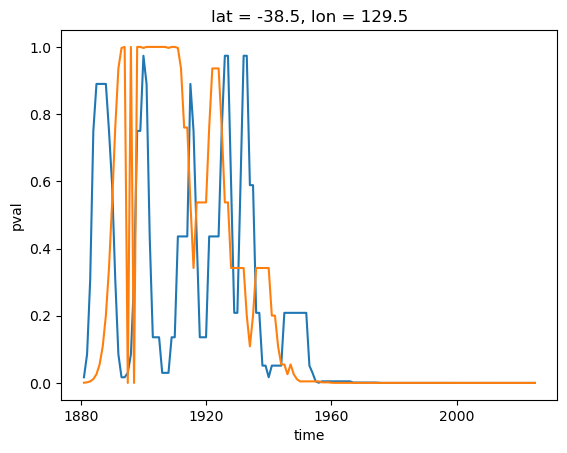

In [259]:
ks_windows_ds.ks_10.sel(variable='pval').sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10')
# ks_windows_ds.ks_80.sel(variable='pval').sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10')
ks_ds.pval.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10')

In [222]:
# %%time
# sel_kwargs = dict(lat=slice(-60, -30), lon=slice(110, 130))
# block_bootstrap_ks = partial(block_bootstrap_statistic, func=ks_statistic_numba)

# ks_bbs_ds = run_windowed_test(
#     block_bootstrap_ks, base_period, window=30,
#     data_ds_window = data_ds_window.sel(**sel_kwargs), base_period_window_ds = base_period_window_ds.sel(**sel_kwargs))

In [184]:
# chunks_best_ultra_small = {'time':-1, 'lat': 180//10, 'lon': 360//36}
# chunks_best_ultra_small_2 = {'window_dim':-1, 'lat': 180//10, 'lon': 360//36}

In [185]:
# data_ds_window = data_ds_window.chunk(chunks_best_ultra_small).persist()
# base_period_window_ds = base_period_window_ds.chunk(chunks_best_ultra_small_2).persist()

# wait(data_ds_window);
# wait(base_period_window_ds);

<h2 style='color: cyan'>Dataset set-up </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

In [53]:
CHUNKS_FOR_PVALUE_TESTS = chunks

In [54]:
window = 30

In [55]:
data_ds_window = (data_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [56]:
wait(data_ds_window);
wait(base_period_window_ds);

In [57]:
data_ds_window

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 145, window_dim: 30)> Size: 1GB
dask.array<rechunk-merge, shape=(180, 360, 145, 30), dtype=float32, chunksize=(18, 36, 145, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1880-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim
Attributes: (6)

In [58]:
data_ds_window.chunks

((18, 18, 18, 18, 18, 18, 18, 18, 18, 18),
 (36, 36, 36, 36, 36, 36, 36, 36, 36, 36),
 (145,),
 (30,))

In [59]:
base_period_window_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360, window_dim: 30)> Size: 8MB
dask.array<getitem, shape=(180, 360, 30), dtype=float32, chunksize=(18, 36, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon         (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * window_dim  (window_dim) object 240B 1880-12-31 00:00:00 ... 1909-12-31 0...
Attributes: (6)

<h2 style='color: cyan'> Overlap Methods - Optimized</h2>

In [62]:
# kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)
kde_kwargs= dict(bw_method=0.6)

### KDE Metrics

In [82]:
# The x-values for the KDE are based upon the max and min
data_max = data_ds.max().persist().values.item()
data_min = data_ds.min().persist().values.item()
num_points = 1000
x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)

data_min, data_max, x.shape

(0.15139812882644543, 11006.290215570136, (1000,))

In [83]:
%%time
# Pre-calculate the base period KDE

base_period_kde = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    base_period_ds,
    input_core_dims=[['time'], ],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=float
).persist()
wait(base_period_kde);

CPU times: user 29.4 s, sys: 3.6 s, total: 33 s
Wall time: 32.9 s


In [84]:
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
latlon_dict = dict(lat=0.5, lon=-29.75, method='nearest')
toe_calc.hellinger_distance_optimized(
    arr_future=data_ds_window.sel(**latlon_dict).isel(time=slice(30, 60)).values,
    kde_base = base_period_kde.sel(**latlon_dict).values,
    x=x
)

120.54694012097345

In [85]:
%%time
hellinger_ds = xr.apply_ufunc(
    toe_calc.hellinger_distance_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()

CPU times: user 3min 32s, sys: 2min 11s, total: 5min 44s
Wall time: 7min 40s


In [86]:
%%time
frac_geom_ds = xr.apply_ufunc(
    toe_calc.fractional_geometric_area_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()
# wait(frac_geom_ds2)

CPU times: user 3min 37s, sys: 2min 14s, total: 5min 51s
Wall time: 7min 42s


In [87]:
x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}
hellinger_ds.attrs =  {'window': window, **hellinger_ds.attrs, **kde_kwargs, **x_attrs}

In [88]:
hellinger_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 221)> Size: 733MB
array([[[[ 20.45, ...,  91.5 ],
         ...,
         [ 13.02, ...,  92.6 ]],

        ...,

        [[ 11.67, ..., 100.  ],
         ...,
         [ 12.47, ..., 100.  ]]],


       ...,


       [[[ 10.67, ...,  89.72],
         ...,
         [ 10.82, ...,  91.56]],

        ...,

        [[ 25.43, ..., 100.  ],
         ...,
         [ 24.33, ..., 100.  ]]]])
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Attributes: (5)

In [89]:
hellinger_ds.attrs

{'window': 30,
 'bw_method': 0.2,
 'bmin': 0.15139812882644543,
 'bmax': 11006.290215570136,
 'num_points': 1000}

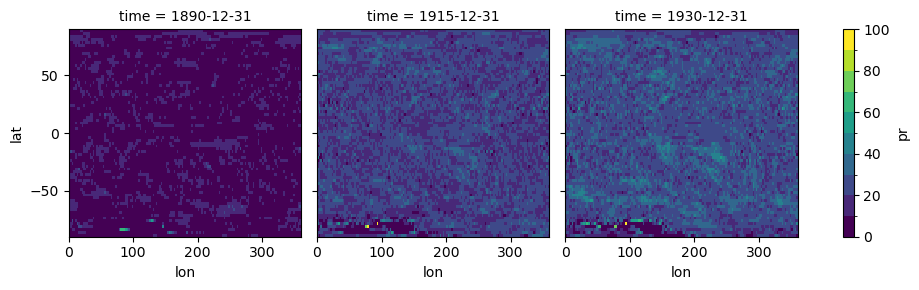

In [90]:
hellinger_ds.isel(time=[10, 35, 50], **member_kwargs).plot(col='time', levels=np.arange(0, 110, 10))

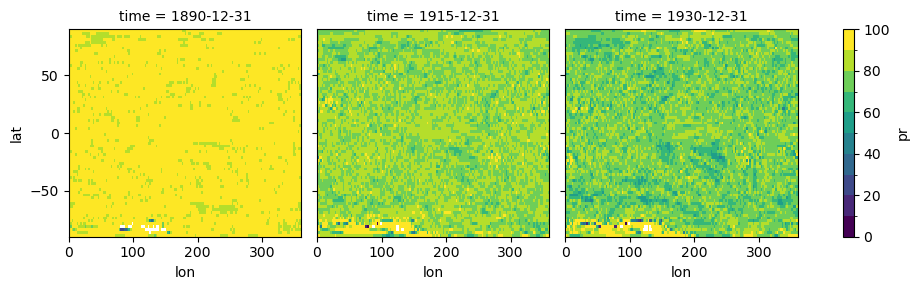

In [91]:
frac_geom_ds.isel(time=[10, 35, 50], **member_kwargs).plot(col='time', levels=np.arange(0, 110, 10))

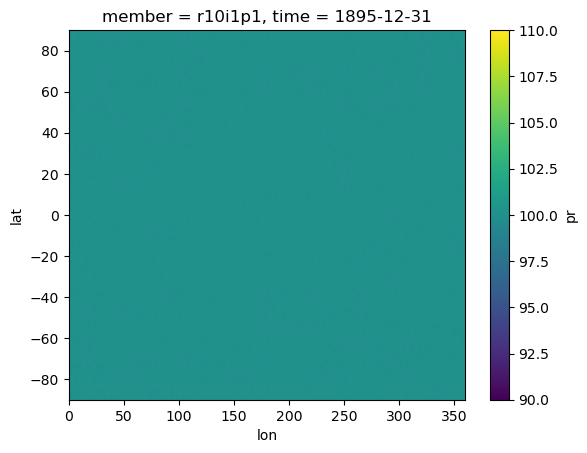

In [92]:
frac_geom_ds.isel(time=window//2, **member_kwargs).plot();

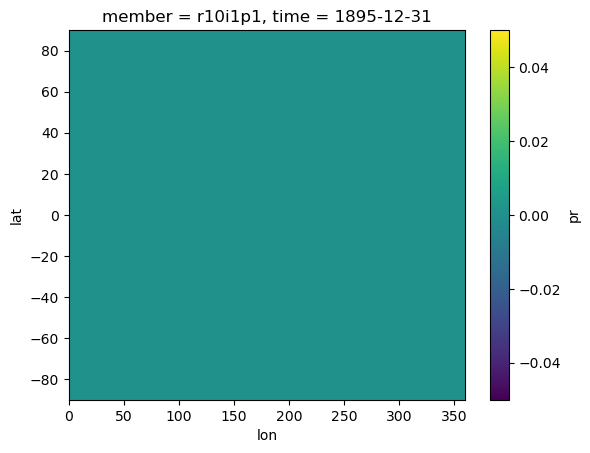

In [93]:
hellinger_ds.isel(time=window//2, **member_kwargs).plot();

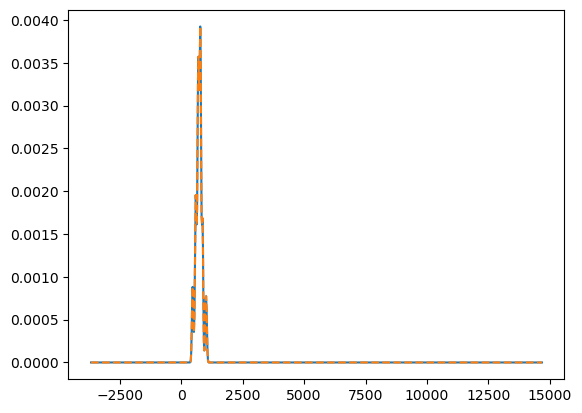

In [94]:
fig, ax1 = plt.subplots(1, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')

test_kde = toe_calc.create_kde_x_exists(
    base_period_ds.sel(**test_loc).isel(**member_kwargs).values, x, **kde_kwargs)

ax1.plot(x, base_period_kde.sel(**test_loc).isel(**member_kwargs).values)
ax1.plot(x, test_kde, linestyle='--')

### Old - Ufunc

In [95]:
# %%time
# perkins_ds = xr.apply_ufunc(
#     toe_calc.perkins_skill_score,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs={'bins': bins},
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute().sortby('lat')

In [96]:
# %%time
# frac_geom_ds = xr.apply_ufunc(
#     toe_calc.fractional_geometric_area,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

In [97]:
# %%time
# hellinger_ds = xr.apply_ufunc(
#     toe_calc.hellinger_distance,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

<h2 style='color: cyan'> P-value Methods </h2>

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [47]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [99]:
%%time
ttest_ds = xr.apply_ufunc(
        toe_calc.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 7min 22s, sys: 4min 11s, total: 11min 34s
Wall time: 16min 18s


In [101]:
%%time
ks_ds = xr.apply_ufunc(
        toe_calc.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


CPU times: user 2min 22s, sys: 1min 15s, total: 3min 38s
Wall time: 4min 35s


In [102]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_availability_mask)

In [103]:
# %%time
# anderson_ds = xr.apply_ufunc(
#     toe_calc.return_anderson_pvalue,
#     data_ds_window,
#     base_period_window_ds,
#     output_dtypes=float, 
#     **rolling_window_kwargs
#     ).compute()

### Mutli-window

In [ ]:
import math

import numpy as np
from scipy import stats

# ranges
t_vals = np.linspace(0, 10, 10001)   # 0 to 10 in 0.001 steps
df_vals = np.arange(2, 2001)         # df from 2 to 2000

# allocate lookup table
lookup = np.empty((len(df_vals), len(t_vals)), dtype=np.float32)

# fill table: loop over df
for i, df in enumerate(df_vals):
    lookup[i, :] = 2 * stats.t.sf(t_vals, df)


import math
from numba import njit
import numpy as np

@njit
def pval_lookup(t, df, t_vals, df_vals, lookup):
    t = abs(t)
    if df > df_vals[-1]:
        # normal approximation using math.erf
        return 2 * (1 - 0.5 * (1 + math.erf(t / math.sqrt(2))))
    if t > t_vals[-1]:
        return 0.0
    j = np.searchsorted(t_vals, t)
    if j >= len(t_vals):
        j = len(t_vals) - 1
    i = np.searchsorted(df_vals, df)
    if i >= len(df_vals):
        i = len(df_vals) - 1
    return lookup[i, j]


%%timeit
p = pval_lookup(2.5, 10, t_vals, df_vals, lookup)
p

In [82]:
import numpy as np
from scipy.stats import t, ksone

# ---------------------------
# Utility: remove NaNs
# ---------------------------
def remove_nans(arr1, arr2):
    return arr1[np.isfinite(arr1)], arr2[np.isfinite(arr2)]

# ---------------------------
# Fast t-tests
# ---------------------------

@njit
def fast_ttest_welch(arr1, arr2):
    """Welch t-test with Satterthwaite df (robust to unequal variances)."""
    n1, n2 = len(arr1), len(arr2)
    mean1, mean2 = arr1.mean(), arr2.mean()
    var1, var2 = arr1.var(ddof=1), arr2.var(ddof=1)

    se = np.sqrt(var1/n1 + var2/n2)
    t_stat = (mean1 - mean2) / se
    df = (var1/n1 + var2/n2)**2 / ((var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1))

    pval = pval_lookup(t_stat, df, t_vals, df_vals, lookup)#2 * (1 - t.cdf(np.abs(t_stat), df))
    return t_stat, pval

# ---------------------------
# HAC / Newey–West t-test
# ---------------------------
def hac_ttest(arr1, arr2, lag=None):
    """
    Welch-like t-test with Newey–West HAC variance adjustment.
    """
    diff = arr1 - arr2
    n = len(diff)
    dbar = diff.mean()

    if lag is None:
        lag = int(np.floor(4 * (n / 100) ** (2/9)))  # common rule-of-thumb

    # long-run variance estimate
    gamma0 = np.var(diff, ddof=1)
    var = gamma0
    for l in range(1, lag+1):
        w = 1 - l/(lag+1)
        gamma_l = np.cov(diff[:-l], diff[l:], ddof=1)[0,1]
        var += 2 * w * gamma_l
    var /= n

    se = np.sqrt(var)
    t_stat = dbar / se
    df = n - 1
    pval = pval_lookup(t_stat, df, t_vals, df_vals, lookup)#2 * (1 - t.cdf(np.abs(t_stat), df))
    return t_stat, pval

# ---------------------------
# Fast KS test
# ---------------------------
def fast_ks(arr1, arr2, n_terms=100):
    """
    Two-sample Kolmogorov–Smirnov test with asymptotic p-value 
    using series expansion (matches SciPy's asymptotic mode).

    Parameters
    ----------
    arr1, arr2 : 1D arrays
        Samples to compare.
    n_terms : int
        Number of terms to keep in the asymptotic series (default 100).

    Returns
    -------
    d_stat : float
        KS statistic (max distance between empirical CDFs).
    pval : float
        Approximate two-sided p-value.
    """
    n1, n2 = len(arr1), len(arr2)

    # observed KS statistic
    data_all = data_all = np.concatenate([arr1, arr2])
    arr1_sorted, arr2_sorted = np.sort(arr1), np.sort(arr2)
    cdf1 = np.searchsorted(arr1_sorted, data_all, side="right") / n1
    cdf2 = np.searchsorted(arr2_sorted, data_all, side="right") / n2
    d_stat = np.max(np.abs(cdf1 - cdf2))

    # effective sample size
    n_eff = n1 * n2 / (n1 + n2)
    x = (np.sqrt(n_eff) + 0.12 + 0.11/np.sqrt(n_eff)) * d_stat

    # asymptotic series expansion for two-sided KS
    j = np.arange(1, n_terms+1)
    terms = (-1)**(j-1) * np.exp(-2 * (x**2) * (j**2))
    pval = 2 * np.sum(terms)

    # guard against numerical issues
    pval = np.clip(pval, 0.0, 1.0)
    return d_stat, pval


# ---------------------------
# Block bootstrap t-test
# ---------------------------
def block_bootstrap_ttest(arr1, arr2, block_size=5, n_boot=1000, rng=None):
    rng = np.random.default_rng(rng)
    n1, n2 = len(arr1), len(arr2)

    def resample(series, n):
        n_blocks = int(np.ceil(n / block_size))
        starts = rng.integers(0, n - block_size + 1, size=n_blocks)
        return np.concatenate([series[s:s+block_size] for s in starts])[:n]

    # observed statistic
    t_stat, _ = fast_ttest_welch(arr1, arr2)

    boot_stats = np.empty(n_boot)
    for i in range(n_boot):
        x_star = resample(arr1, n1)
        y_star = resample(arr2, n2)
        boot_stats[i], _ = fast_ttest_welch(x_star, y_star)

    pval = np.mean(np.abs(boot_stats) >= np.abs(t_stat))
    return t_stat, pval

# ---------------------------
# Block bootstrap KS test
# ---------------------------
def block_bootstrap_ks(arr1, arr2, block_size=5, n_boot=1000, rng=None):
    """
    Block bootstrap Kolmogorov–Smirnov test.
    
    Parameters
    ----------
    arr1, arr2 : 1D arrays
        Input samples.
    block_size : int
        Length of resampling blocks.
    n_boot : int
        Number of bootstrap replicates.
    rng : np.random.Generator or None
        Random generator.

    Returns
    -------
    d_stat : float
        Observed KS statistic between arr1 and arr2.
    pval : float
        Bootstrap p-value (fraction of replicates >= observed statistic).
    """
    rng = np.random.default_rng(rng)
    n1, n2 = len(arr1), len(arr2)

    # observed KS
    data_all = np.concatenate([arr1, arr2])
    cdf1 = np.searchsorted(np.sort(arr1), data_all, side="right") / n1
    cdf2 = np.searchsorted(np.sort(arr2), data_all, side="right") / n2
    d_obs = np.max(np.abs(cdf1 - cdf2))

    def resample(series, n):
        n_blocks = int(np.ceil(n / block_size))
        starts = rng.integers(0, n - block_size + 1, size=n_blocks)
        return np.concatenate([series[s:s+block_size] for s in starts])[:n]

    boot_stats = np.empty(n_boot)
    for i in range(n_boot):
        x_star = resample(arr1, n1)
        y_star = resample(arr2, n2)
        data_all_star = np.concatenate([x_star, y_star])
        cdf1_star = np.searchsorted(np.sort(x_star), data_all_star, side="right") / n1
        cdf2_star = np.searchsorted(np.sort(y_star), data_all_star, side="right") / n2
        boot_stats[i] = np.max(np.abs(cdf1_star - cdf2_star))

    pval = np.mean(boot_stats >= d_obs)
    return d_obs, pval

# ---------------------------
# FDR correction (BH)
# ---------------------------
def fdr_bh(pvals, alpha=0.05):
    pvals = np.asarray(pvals)
    n = len(pvals)
    sort_idx = np.argsort(pvals)
    sorted_p = pvals[sort_idx]

    thresholds = alpha * (np.arange(1, n+1) / n)
    below = sorted_p <= thresholds
    if not np.any(below):
        return np.zeros_like(pvals, dtype=bool), 0.0

    k = np.max(np.where(below)[0])
    pval_thresh = sorted_p[k]
    rejected = pvals <= pval_thresh
    return rejected, pval_thresh


In [91]:
def __ttest_welch_from_stats(n1, mean1, var1, n2, mean2, var2):
    """Welch t-test given precomputed stats."""
    se = np.sqrt(var1/n1 + var2/n2)
    t_stat = (mean1 - mean2) / se
    df = (var1/n1 + var2/n2)**2 / ((var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1))
    pval = pval_lookup(t_stat, df, t_vals, df_vals, lookup)
    return t_stat, pval

def fast_ttest_welch_v2(arr1, arr2):
    """Welch t-test wrapper that computes stats from arrays."""
    n1, n2 = len(arr1), len(arr2)
    mean1, mean2 = arr1.mean(), arr2.mean()
    var1, var2 = arr1.var(ddof=1), arr2.var(ddof=1)
    return __ttest_welch_from_stats(n1, mean1, var1, n2, mean2, var2)


In [81]:
%%timeit
block_bootstrap_ks(x1, y1)

191 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
@njit
def concat_arrays(a, b):
    out = np.empty(a.size + b.size, dtype=a.dtype)
    out[:a.size] = a
    out[a.size:] = b
    return out

In [90]:
%%timeit
fast_ks(x1, y1)

65.8 μs ± 3.75 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [80]:
%%timeit
ks_2samp(x1, y1)

357 μs ± 16.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



T-test (same distribution):
  Fast  -> stat = 1.0416, p = 0.2980
  SciPy -> stat = 1.0416, p = 0.2982

T-test (different mean):
  Fast  -> stat = -4.5474, p = 0.0000
  SciPy -> stat = -4.5474, p = 0.0000

KS test (same distribution):
  Fast  -> stat = 0.1050, p = 0.2078
  SciPy -> stat = 0.1050, p = 0.2205

KS test (different mean):
  Fast  -> stat = 0.1950, p = 0.0008
  SciPy -> stat = 0.1950, p = 0.0010

KS test (different shape):
  Fast  -> stat = 0.1350, p = 0.0475
  SciPy -> stat = 0.1350, p = 0.0521


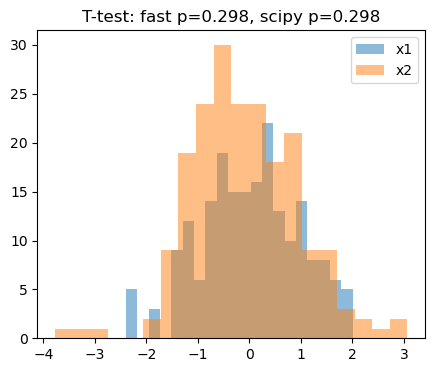

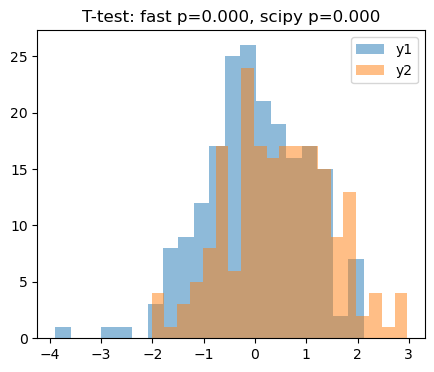

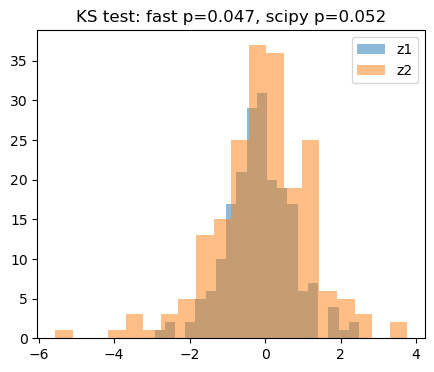

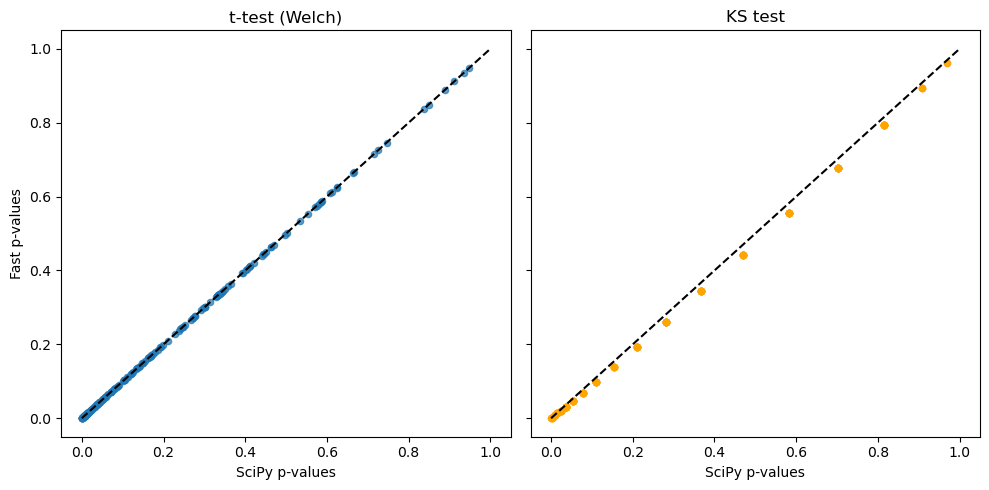

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp

# ---------------------------
# Generate test data
# ---------------------------
rng = np.random.default_rng(0)

x1 = rng.normal(0, 1, 200)
x2 = rng.normal(0, 1, 200)       # same distribution
y1 = rng.normal(0, 1, 200)
y2 = rng.normal(0.5, 1, 200)     # different mean
z1 = rng.normal(0, 1, 200)
z2 = rng.laplace(0, 1, 200)      # different shape

# ---------------------------
# Print comparisons
# ---------------------------
def compare_ttests(a, b, name=""):
    stat_fast, p_fast = fast_ttest_welch(a, b)
    res_scipy = ttest_ind(a, b, equal_var=False)  # Welch
    print(f"\nT-test ({name}):")
    print(f"  Fast  -> stat = {stat_fast:.4f}, p = {p_fast:.4f}")
    print(f"  SciPy -> stat = {res_scipy.statistic:.4f}, p = {res_scipy.pvalue:.4f}")

def compare_kstest(a, b, name=""):
    stat_fast, p_fast = fast_ks(a, b)
    res_scipy = ks_2samp(a, b)
    print(f"\nKS test ({name}):")
    print(f"  Fast  -> stat = {stat_fast:.4f}, p = {p_fast:.4f}")
    print(f"  SciPy -> stat = {res_scipy.statistic:.4f}, p = {res_scipy.pvalue:.4f}")

# Run the comparisons
compare_ttests(x1, x2, name="same distribution")
compare_ttests(y1, y2, name="different mean")

compare_kstest(x1, x2, name="same distribution")
compare_kstest(y1, y2, name="different mean")
compare_kstest(z1, z2, name="different shape")

# ---------------------------
# Visual: histograms + p-values
# ---------------------------
def plot_test_demo(a, b, test="t-test", label_a="A", label_b="B"):
    fig, ax = plt.subplots(figsize=(5,4))
    ax.hist(a, bins=20, alpha=0.5, label=label_a)
    ax.hist(b, bins=20, alpha=0.5, label=label_b)

    if test=="t-test":
        _, p_fast = fast_ttest_welch(a, b)
        p_scipy = ttest_ind(a, b, equal_var=False).pvalue
        title = f"T-test: fast p={p_fast:.3f}, scipy p={p_scipy:.3f}"
    elif test=="ks":
        _, p_fast = fast_ks(a, b)
        p_scipy = ks_2samp(a, b).pvalue
        title = f"KS test: fast p={p_fast:.3f}, scipy p={p_scipy:.3f}"

    ax.set_title(title)
    ax.legend()
    plt.show()

plot_test_demo(x1, x2, test="t-test", label_a="x1", label_b="x2")  # same dist
plot_test_demo(y1, y2, test="t-test", label_a="y1", label_b="y2")  # diff mean
plot_test_demo(z1, z2, test="ks", label_a="z1", label_b="z2")      # diff shape

# ---------------------------
# Visual: scatterplots fast vs SciPy p-values
# ---------------------------
vals = []
for i in range(200):
    a = rng.normal(0, 1, 100)
    b = rng.normal(0.2, 1, 100)
    _, pf_t = fast_ttest_welch(a, b)
    ps_t = ttest_ind(a, b, equal_var=False).pvalue
    _, pf_k = fast_ks(a, b)
    ps_k = ks_2samp(a, b).pvalue
    vals.append((pf_t, ps_t, pf_k, ps_k))
vals = np.array(vals)

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

axes[0].scatter(vals[:,1], vals[:,0], s=20, alpha=0.7)
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_title("t-test (Welch)")
axes[0].set_xlabel("SciPy p-values")
axes[0].set_ylabel("Fast p-values")

axes[1].scatter(vals[:,3], vals[:,2], s=20, alpha=0.7, color="orange")
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_title("KS test")
axes[1].set_xlabel("SciPy p-values")

plt.tight_layout()
plt.show()


In [46]:
window = 30

In [74]:
data_ds_window = (data_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [99]:
%%time
ttest_ds = xr.apply_ufunc(
        toe_calc.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 7min 22s, sys: 4min 11s, total: 11min 34s
Wall time: 16min 18s


In [101]:
%%time
ks_ds = xr.apply_ufunc(
        toe_calc.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


CPU times: user 2min 22s, sys: 1min 15s, total: 3min 38s
Wall time: 4min 35s


In [75]:
wait(data_ds_window);
wait(base_period_window_ds);

### Verification of p-value test
- Comparison with 1d rolling func
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [104]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [105]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length=base_period.length+1)

In [106]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).isel(**member_kwargs).values)

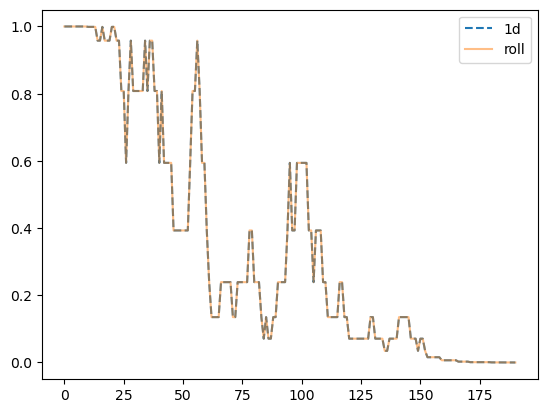

In [107]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2)), **member_kwargs).values, label='roll', alpha=0.5)
plt.legend()

<h2 style='color: cyan'> Signal-to-Noise </h2>

In [108]:
# Calculate the wegithed mean
# data_ds_smean = climate_utils.weighted_lat_lon_mean(data_anom_ds).compute()

In [109]:
# data_ds_smean.plot()

### Signal

In [110]:
ds_signal_lowess = xr.apply_ufunc(
    my_stats.apply_lowess, 
    data_anom_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    kwargs = dict(window=41),
    dask='parallelized',
    output_dtypes=[float]
).compute()

In [111]:
ds_signal_mean = data_anom_ds.rolling(time=window, center=True).mean().persist()
wait(ds_signal_mean);

In [112]:
signal_pol4_da = my_stats.trend_fit(
    data_anom_ds.chunk({'time':-1, 'lat':10}),
    order=4, method='polynomial').compute()

### Noise

In [113]:
### LOWESS
ds_noise_series_lowess = (data_anom_ds - ds_signal_lowess).compute()
# Noise is std of detrended data
ds_noise_lowess_full = ds_noise_series_lowess.std(dim='time')

noise_lowess_base_period_ds = ds_noise_series_lowess.where(
    ds_noise_series_lowess.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

In [114]:
# Rolling mean

ds_noise_series_mean = (data_anom_ds - ds_signal_mean).compute()

ds_noise_mean_base_period = ds_noise_series_mean.where(
    ds_noise_series_mean.time.dt.year.isin (np.arange(*base_period.value)), drop=True).std(dim='time')

In [115]:
# 4th order polynomial

ds_noise_series_poly4 = (data_anom_ds - signal_pol4_da).compute()

noise_poly4_base_period_ds = ds_noise_series_poly4.where(
    ds_noise_series_poly4.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

In [116]:
# data_detrend_mean = (data_anom_ds - ds_signal_mean).persist()
# Detrended usign lowess or else 2 x 15 year periods on either end is lost
std_mean_roll_ds = ds_noise_series_mean.rolling(time=window, center=True).std().persist()
std_lowess_roll_ds = ds_noise_series_lowess.rolling(time=window, center=True).std().persist()

In [117]:
rolling_noise_mean_ds = (np.sqrt(1/2*(noise_poly4_base_period_ds**2+std_mean_roll_ds**2))).persist()
wait(rolling_noise_mean_ds);

In [118]:
rolling_noise_lowess_ds = (np.sqrt(1/2*(noise_lowess_base_period_ds**2+std_lowess_roll_ds**2))).persist()
wait(rolling_noise_lowess_ds);

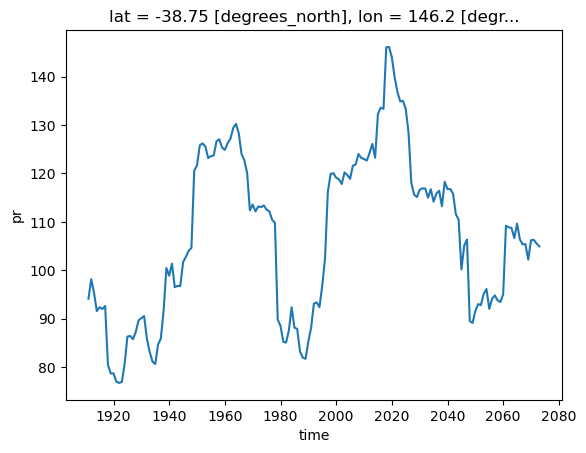

In [119]:
std_mean_roll_ds.isel(**member_kwargs).sel(lat=-39, lon=145, method='nearest').plot()

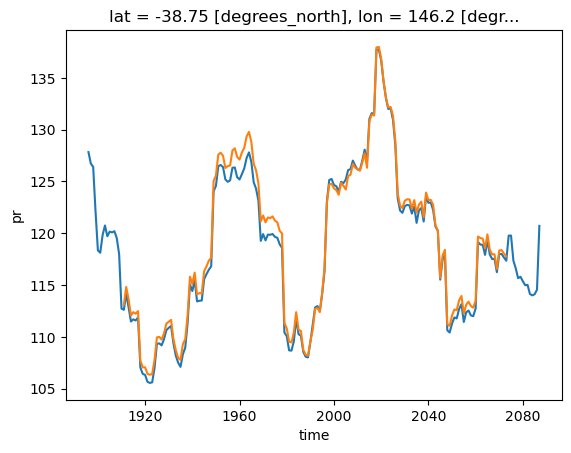

In [120]:
rolling_noise_lowess_ds.isel(**member_kwargs).sel(lat=-39, lon=145, method='nearest').plot()
rolling_noise_mean_ds.isel(**member_kwargs).sel(lat=-39, lon=145, method='nearest').plot()

### S/N ratio

In [121]:
# S/N Ratio
sn_lowess_full_ds = ds_signal_lowess/ds_noise_lowess_full
sn_lowess_base_period_ds = ds_signal_lowess/noise_lowess_base_period_ds

In [122]:
sn_poly4_base_ds = signal_pol4_da/noise_poly4_base_period_ds

In [123]:
sn_mean_base_ds = ds_signal_mean/ds_noise_mean_base_period
wait(sn_mean_base_ds);

In [124]:
sn_lowess_roll_ds = (ds_signal_lowess/rolling_noise_lowess_ds).persist()
wait(sn_lowess_roll_ds);

In [125]:
sn_mean_roll_ds = (ds_signal_mean/rolling_noise_mean_ds).persist()
wait(sn_mean_roll_ds);

In [126]:
# base_period_std = data_detrend_mean.sel(time=slice(str(base_period.start), str(base_period.end))).std(dim='time').persist()

In [127]:
# Get lowess filtered version
# ds_smean_lowess = my_stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [128]:
# %%time
# return_hawkins_signal_and_noise_partial = partial(toe_calc.return_hawkins_signal_and_noise, 
#                                                   gt=ds_smean_lowess.values)

# ds_signal_hawkins, ds_noise_series_hawkins = xr.apply_ufunc(
#     return_hawkins_signal_and_noise_partial,
#     data_anom_ds,
#     input_core_dims=[['time']], 
#     output_core_dims=[['time'], ['time']], 
#     dask='parallelized', 
#     vectorize=True,
#     output_dtypes=[float, float],
# )

# ds_signal_hawkins = ds_signal_hawkins.compute()
# ds_noise_series_hawkins = ds_noise_series_hawkins.compute()

In [129]:
# # Noise 
# ds_noise_hawkins_full = ds_noise_series_hawkins.std(dim='time').compute()

# ds_noise_hawkins_base_period = ds_noise_series_hawkins.where(
#     ds_noise_series_hawkins.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# # S/N Ratio 
# ds_sn_hawkins_full = ds_signal_hawkins/ds_noise_hawkins_full
# ds_sn_hawkins_base_period = ds_signal_hawkins/ds_noise_hawkins_base_period

### Plot Verificaiton

In [130]:
lat_lon_sp = dict(lat=-38, lon=145, method='nearest')

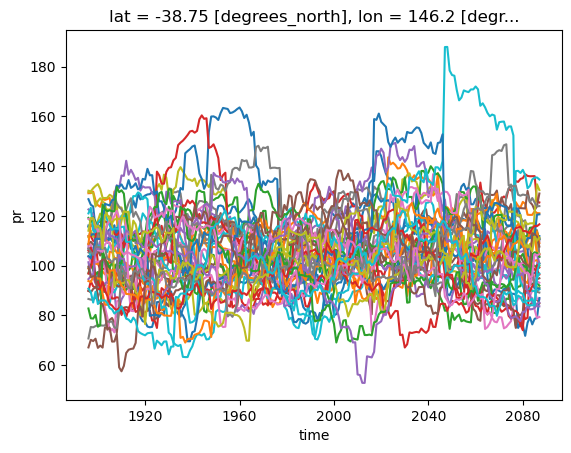

In [131]:
std_lowess_roll_ds.sel(**lat_lon_sp).plot(**plot_kwargs);

Text(0.5, 1.0, 'S/N')

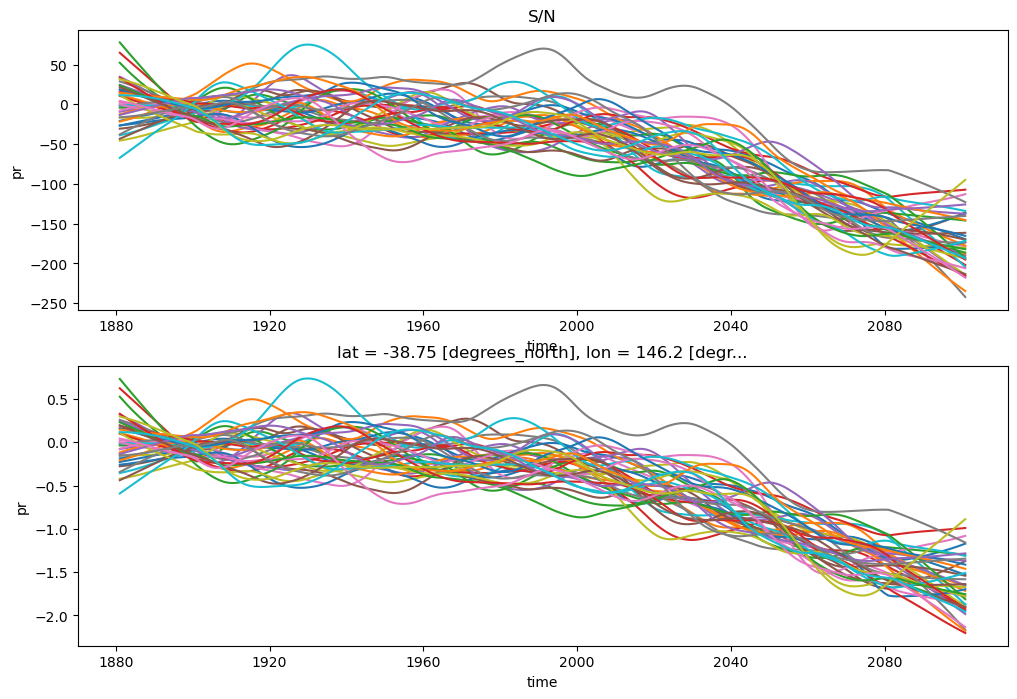

In [132]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
ds_signal_lowess.sel(**lat_lon_sp).plot(ax=axes[0], **plot_kwargs);

sn_lowess_full_ds.sel(**lat_lon_sp).plot(ax=axes[1], **plot_kwargs);


axes[0].set_title('Signal')
axes[0].set_title('S/N')

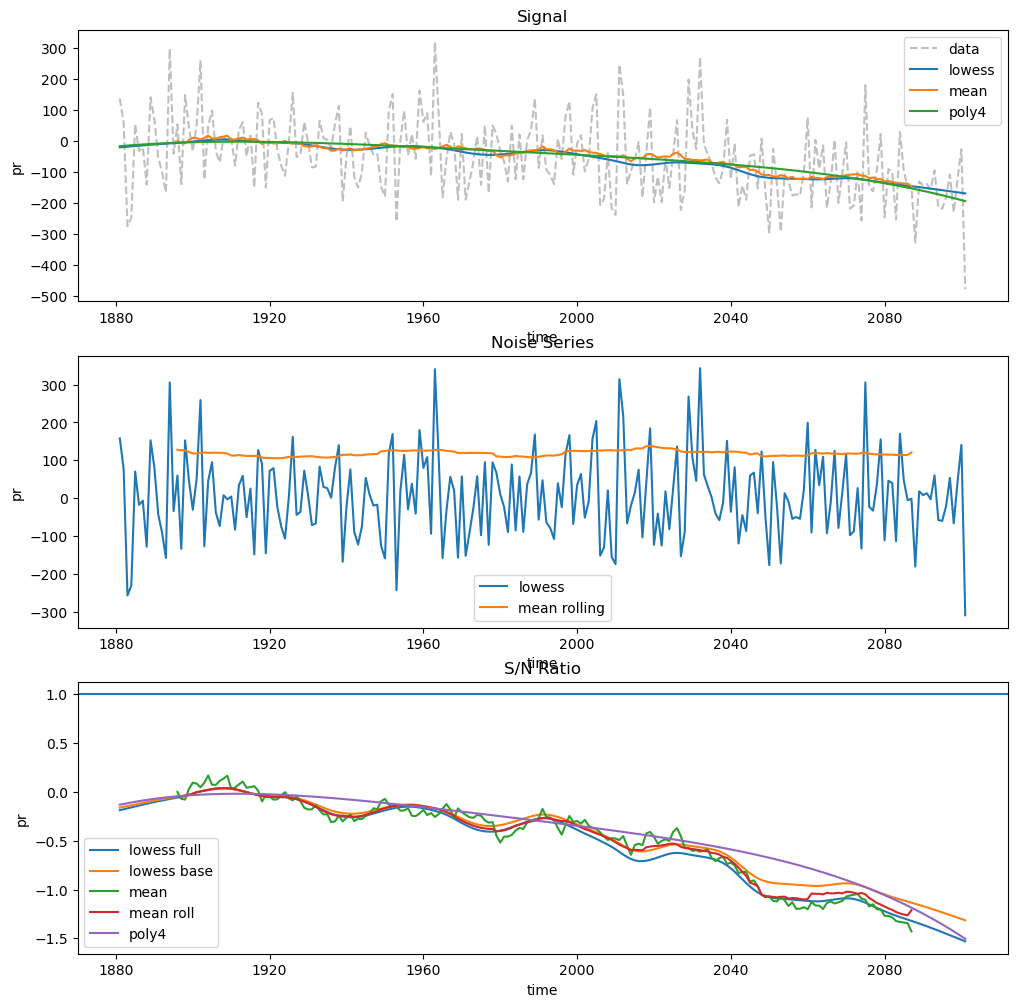

In [133]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax1 = axes[0]
data_anom_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='data', ax=ax1, color='grey', linestyle='--', alpha=0.5)
ds_signal_lowess.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='lowess', ax=ax1)
ds_signal_mean.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='mean', ax=ax1)
signal_pol4_da.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='poly4', ax=ax1)
# ds_signal_hawkins.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='hawkins', ax=ax1)

ax1.set_title('Signal')
ax1.legend()

#####
ax2= axes[1]
ds_noise_series_lowess.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='lowess', ax=ax2)
# ds_noise_series_hawkins.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='hawkins', ax=ax2)
rolling_noise_lowess_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='mean rolling', ax=ax2)
ax2.set_title('Noise Series')

ax2.legend()


####
ax3= axes[2]
sn_lowess_full_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='lowess full', ax=ax3)
sn_lowess_base_period_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='lowess base', ax=ax3)
sn_mean_base_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='mean', ax=ax3)
sn_lowess_roll_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='mean roll', ax=ax3)
sn_poly4_base_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='poly4', ax=ax3)

# ds_sn_hawkins_full.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='hawkins full', ax=ax3)
# ds_sn_hawkins_base_period.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='hawkins base', ax=ax3)
ax3.set_title('S/N Ratio')
ax3.axhline(1)
ax3.legend()

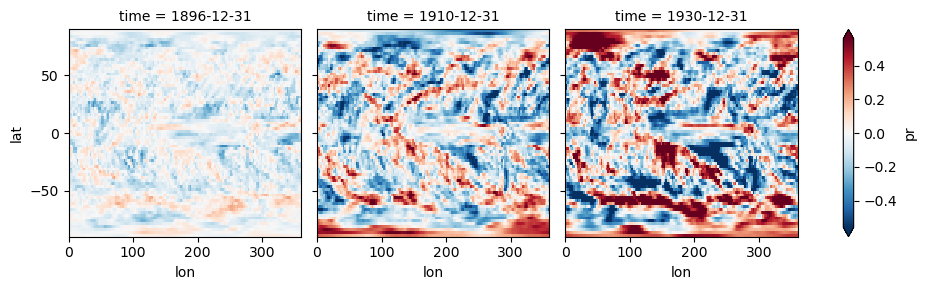

In [134]:
sn_lowess_roll_ds.isel(time=[16, 30, 50], **member_kwargs).plot(col='time', robust=True)

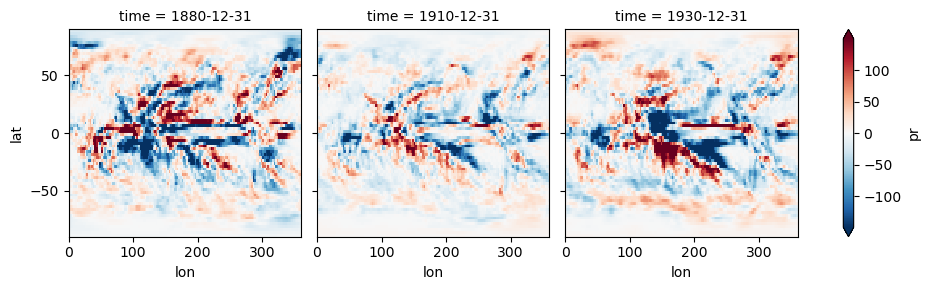

In [135]:
ds_signal_lowess.isel(time=[0, 30, 50], **member_kwargs).plot(col='time', robust=True)

<h1 style='color: yellow'>  Model S/N Ratios </h1>

#### piControl Data

In [28]:
# # PICONTROL_PATH = '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320'
# # PICONTROL_PATH = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316"
# ESMPICONTROL_PATH =\
#     ("/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/"
#     "esm-piControl/r1i1p1f2/Amon/tas/gn/v20250307")
# # ESMPCONTROL_PATH2 = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/esm-piControl/r1i1p1f2/Amon/tas/gn/v20250307'

# # ESM_PI_CONTROL_PATH_3 = ("/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/"
#                         # "esm-piControl/r1i3p1f2/Amon/tas/gn/v20250307")

In [150]:
# # le_pi_ds = xr.open_mfdataset(os.path.join(ESM_PI_CONTROL_PATH_3, '*.nc'), use_cftime=True).persist()
# le_pi_ds = xr.open_mfdataset(os.path.join(ESMPICONTROL_PATH, '*.nc'),
#                              use_cftime=True).chunk(PI_CHUNKS).persist()
# le_pi_ds = le_pi_ds['tas'].resample(time='YE').mean().persist()

# le_pi_ds.to_zarr(
#     '/g/data/w40/ab2313/time_of_emergence/access_esmpicontrol_2.zarr', mode='w')
# wait(le_pi_ds);

In [151]:
# PICONTROL_PATH = '/g/data/w40/ab2313/time_of_emergence/access_picontrol.zarr'
# PICONTROL_PATH_PR = '/g/data/w40/ab2313/time_of_emergence/access_picontrol_pr.zarr'
# # ESMPICONTROL_PATH = '/g/data`/w40/ab2313/time_of_emergence/access_esmpicontrol.zarr'

In [152]:
# PICONTROL_PATH = ('/g/data/fs38/publications/CMIP6/CMIP/'
#                   'CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/pr/gn/v20210316/')

In [153]:
import climtas

In [154]:
PI_CHUNKS = {'time':-1, 'lat':'auto', 'lon':'auto'}

In [155]:
PICONTROL_PATH_DICT = {
    'tas': '/g/data/w40/ab2313/time_of_emergence/access_picontrol.zarr',
    'pr': '/g/data/w40/ab2313/time_of_emergence/access_picontrol_pr.zarr'
}

In [156]:
PICONTROL_PATH = PICONTROL_PATH_DICT[variable]
PICONTROL_PATH

'/g/data/w40/ab2313/time_of_emergence/access_picontrol_pr.zarr'

In [157]:
le_pi_raw_ds = xr.open_dataset(PICONTROL_PATH, engine='zarr', use_cftime=True)[variable].chunk(PI_CHUNKS).persist()#.compute()

In [158]:
le_pi_raw_ds = le_pi_raw_ds.compute()

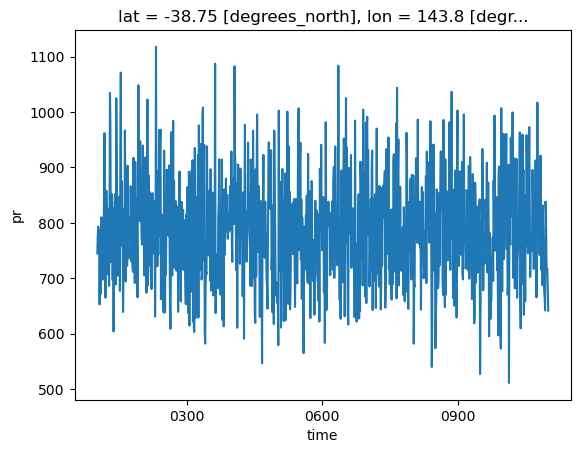

In [159]:
le_pi_raw_ds.sel(lat=-39, lon=145, method='nearest').plot()

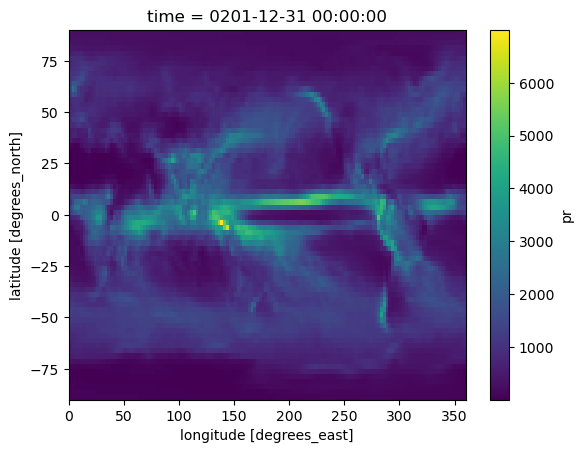

In [160]:
le_pi_raw_ds.isel(time=100).plot()

In [161]:
# if variable == 'pr':
#     days_per_month =  le_pi_raw_ds.time.dt.days_in_month  
#     le_pi_raw_ds = le_pi_raw_ds * 86400 * days_per_month  
#     le_pi_raw_ds = le_pi_raw_ds.resample(time="YE").sum().compute()

In [162]:
le_pi_raw_ds

<xarray.DataArray 'pr' (time: 1000, lat: 72, lon: 144)> Size: 83MB
50.54 50.21 49.8 49.43 49.01 48.68 48.36 ... 272.7 273.6 275.0 276.6 277.9 278.5
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.3 353.8 356.2 358.7
  * time     (time) object 8kB 0101-12-31 00:00:00 ... 1100-12-31 00:00:00

In [163]:
target_grid = data_ds.isel(time=0, member=0).drop_vars(['time', 'member']).compute()
target_grid

<xarray.DataArray 'pr' (lat: 72, lon: 144)> Size: 83kB
59.28 58.69 58.21 57.74 57.26 56.82 ... 215.2 213.9 212.7 212.4 211.9 212.6
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Attributes: (1)

In [164]:
if variable == 'pr':
    print('Using conservative')
    weights = climtas.regrid.cdo_generate_weights(le_pi_raw_ds, target_grid, method='con')
    regridder = climtas.regrid.Regridder(weights = weights)
else:
    print('Default')
    regridder = climtas.regrid.Regridder(le_pi_raw_ds, target_grid)

Using conservative


In [165]:
le_pi_ds = regridder.regrid(le_pi_raw_ds).persist()
le_pi_ds = le_pi_ds.set_index(lat='lat', lon='lon')  # makes them proper indexes (reset for some reason)
wait(le_pi_ds);

In [166]:
le_pi_ds

<xarray.DataArray 'pr' (time: 1000, lat: 72, lon: 144)> Size: 83MB
dask.array<chunksize=(1000, 72, 144), meta=np.ndarray>
Coordinates:
  * time     (time) object 8kB 0101-12-31 00:00:00 ... 1100-12-31 00:00:00
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.3 353.8 356.2 358.7

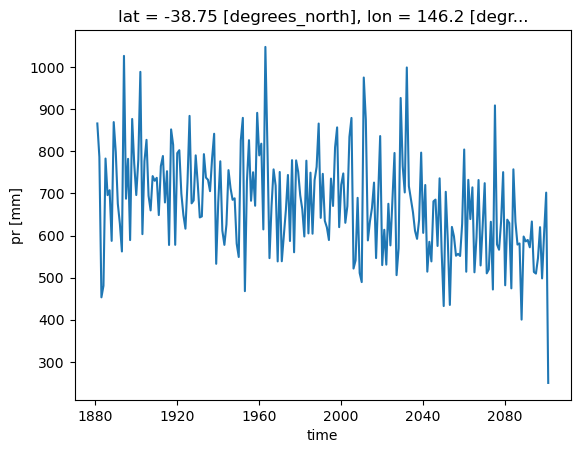

In [167]:
data_ds.sel(lat=-39, lon=145, method='nearest').isel(member=0).plot()

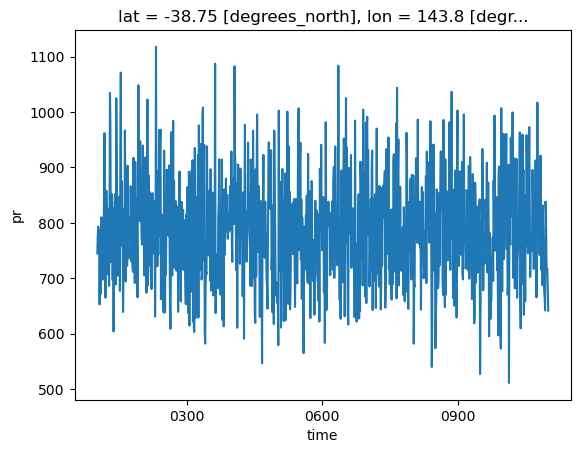

In [168]:
le_pi_ds.sel(lat=-39, lon=145, method='nearest').plot()

In [169]:
le_pi_ds['lat'] = data_ds.lat.values
le_pi_ds['lon'] = data_ds.lon.values

In [170]:
np.testing.assert_equal(data_anom_ds.lon.values, le_pi_ds.lon.values)
np.testing.assert_equal(data_anom_ds.lat.values, le_pi_ds.lat.values)

In [173]:
le_pi_ds.sel(lat=-39, lon=145, method='nearest')

<xarray.DataArray 'pr' (time: 1000)> Size: 8kB
dask.array<chunksize=(1000,), meta=np.ndarray>
Coordinates:
  * time     (time) object 8kB 0101-12-31 00:00:00 ... 1100-12-31 00:00:00
    lat      float64 8B -38.75
    lon      float64 8B 146.2

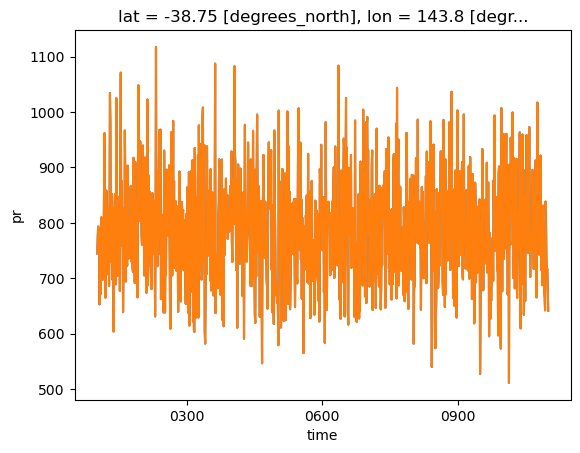

In [175]:
le_pi_ds.sel(lat=-39, lon=143, method='nearest').plot()
le_pi_raw_ds.sel(lat=-39, lon=143, method='nearest').plot()

#### New S/N

In [159]:
singal_ens_median = data_anom_ds.median(dim='member').compute()
wait(singal_ens_median);

In [160]:
le_pi_ds_noise = le_pi_ds.std(dim='time')

In [161]:
# Noise series is detrended data
ds_noise_series_mean = (data_anom_ds - ds_signal_mean).compute()

ds_noise_mean_base_period = ds_noise_series_mean.where(
    ds_noise_series_mean.time.dt.year.isin (np.arange(*base_period.value)), drop=True).std(dim='time')

In [162]:
# Noise series is detrended data
ds_noise_series_ens_median = (data_anom_ds - singal_ens_median).compute()

ds_noise_series_ens_median_base_period = ds_noise_series_ens_median.where(
    ds_noise_series_ens_median.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

In [163]:
sn_ens_med_base_period = singal_ens_median/ds_noise_series_ens_median_base_period

In [164]:
sn_mean_base = (ds_signal_mean/ds_noise_mean_base_period).persist()

In [165]:
sn_ens_med_pi = (singal_ens_median/le_pi_ds_noise).persist()

In [166]:
sn_lowess_pi = (ds_signal_lowess/le_pi_ds_noise).persist()

In [167]:
sn_mean_pi = (ds_signal_mean/le_pi_ds_noise).persist()

In [168]:
# sn_lowess_roll = ds_signal_lowess/rolling_noise_lowess_ds 

In [169]:
sn_pol4_pi_ds = signal_pol4_da/le_pi_ds_noise

Text(0.5, 1.0, 'mean - base period')

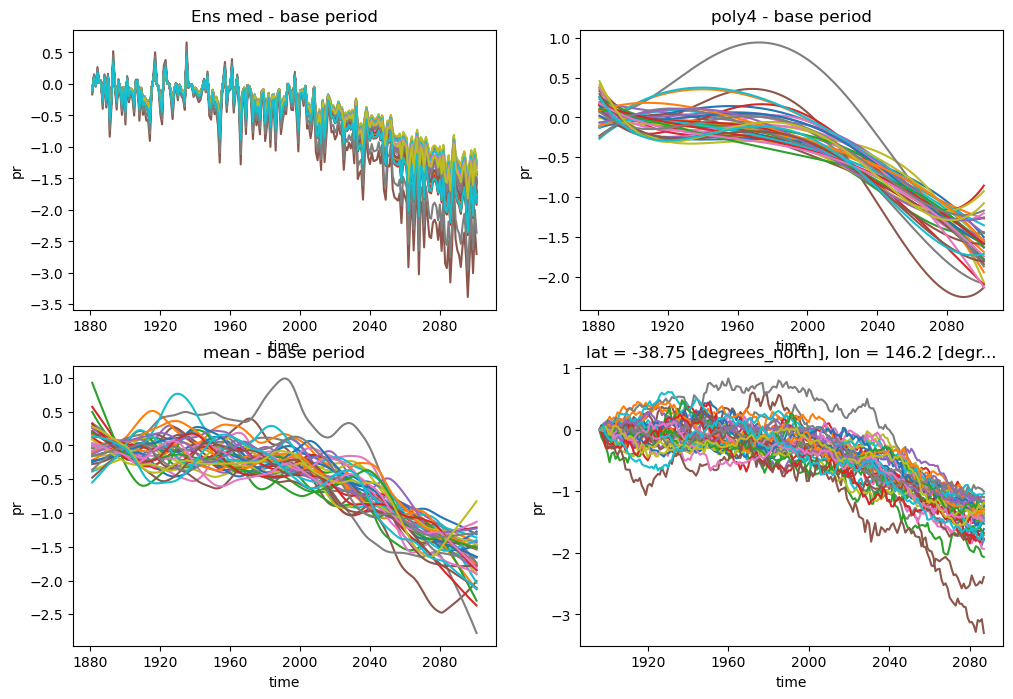

In [170]:
fig = plt.figure(figsize=(12, 8))
axes = [fig.add_subplot(2, 2, i+1) for i in range(4)]

sn_ens_med_base_period.sel(lat=-39, lon=145, method='nearest').plot(ax=axes[0], hue='member', add_legend=False);
sn_poly4_base_ds.sel(lat=-39, lon=145, method='nearest').plot(ax=axes[1],hue='member', add_legend=False);
sn_lowess_base_period_ds.sel(lat=-39, lon=145, method='nearest').plot(ax=axes[2],hue='member', add_legend=False);
sn_mean_base.sel(lat=-39, lon=145, method='nearest').plot(ax=axes[3],hue='member', add_legend=False);

axes[0].set_title('Ens med - base period')
axes[1].set_title('poly4 - base period')
axes[2].set_title('lowess - base period')
axes[2].set_title('mean - base period')

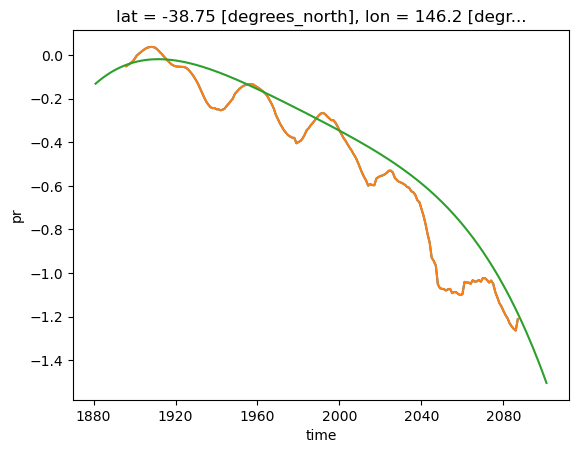

In [171]:
# sn_lowess_roll.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()
sn_lowess_roll_ds.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()
sn_poly4_base_ds.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()

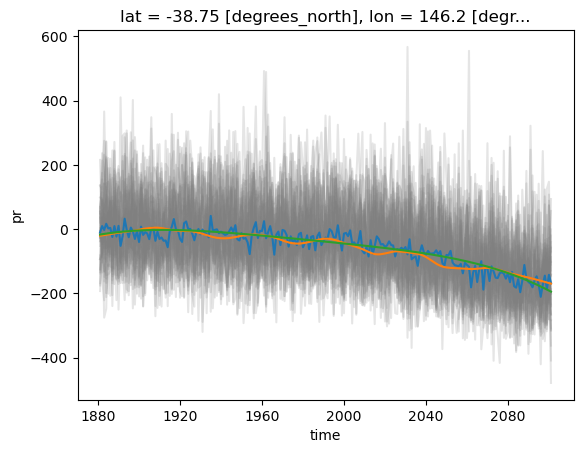

In [172]:
data_anom_ds.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False, color='grey', alpha=0.2);
singal_ens_median.sel(lat=-39, lon=145, method='nearest').plot()
ds_signal_lowess.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()
signal_pol4_da.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()

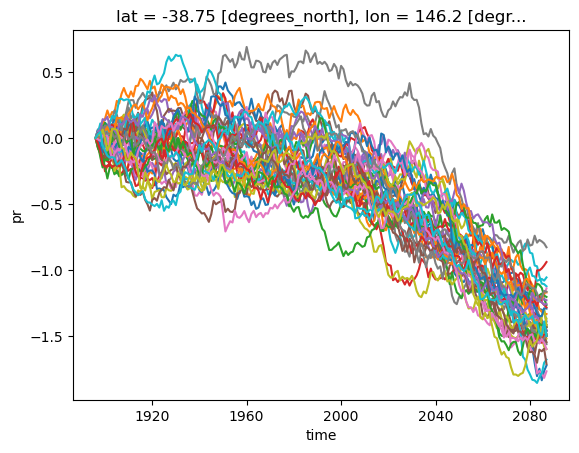

In [173]:
sn_mean_pi.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);

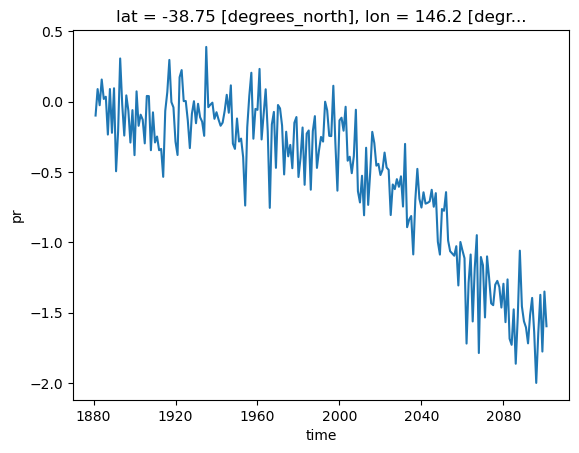

In [174]:
sn_ens_med_pi.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False)

<h1 style='color: yellow'>  Data Mering and Save </h1>

In [206]:
SIGNAL_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'signal.zarr')
TOE_METRICS_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'toe_metrics.zarr')
DATA_AVAILABILITY_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'data_availability_mask.zarr')

In [207]:
# ds_signal_hawkins.name = 'signal_hawkins'
# ds_noise_series_hawkins.name = 'noise_hawkins'
# ds_sn_hawkins_full.name = 'sn_hawkins_full'
# ds_sn_hawkins_base_period.name = 'sn_hawkins_base'

In [208]:
if 'member' in list(ds_signal_lowess.coords):
    singal_ens_median.name = 'signal_ens_med'
    ds_noise_series_ens_median.name = 'noise_ens_med'
    sn_ens_med_pi.name = 'sn_ens_med_pi'
    sn_lowess_pi.name = 'sn_lowess_pi'
    sn_ens_med_base_period.name = 'sn_ens_med_base'
    sn_mean_pi.name = 'sn_mean_pi'
    sn_pol4_pi_ds.name = 'sn_poly_pi'

In [209]:
ds_signal_lowess.name = 'signal_lowess'
signal_pol4_da.name = 'signal_poly4'
ds_signal_mean.name = 'signal_mean'

ds_noise_series_poly4.name = 'noise_poly4'
ds_noise_series_lowess.name = 'noise_lowess'

rolling_noise_lowess_ds.name = 'noise_lowess_rolling'
rolling_noise_mean_ds.name = 'noise_mean_rolling'

In [210]:
sn_lowess_base_period_ds.name = 'sn_lowess_base'
sn_mean_base_ds.name = 'sn_mean_base'
sn_poly4_base_ds.name = 'sn_poly4_base'

sn_lowess_full_ds.name = 'sn_lowess_full'

sn_lowess_roll_ds.name = 'sn_lowess_roll'
sn_mean_roll_ds .name = 'sn_mean_roll'

ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
# perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hellinger_ds.name = 'hd'

In [211]:
# sn_pi.attrs['long_name'] = 'S/N Ratio (LOWESS, piControl)'
# sn_ens_med.attrs['long_name'] = 'S/N Ratio (Ensesemble Median, Base)'

In [212]:
# Set long name attributes for each variable
# ds_sn_hawkins_full.attrs['long_name'] = 'S/N Ratio (Hawkins, full)'
# ds_sn_hawkins_base_period.attrs['long_name'] = 'S/N Ratio (Hawkins, base)'

sn_lowess_full_ds.attrs['long_name'] = 'S/N Ratio (LOWESS, full)'
sn_lowess_base_period_ds.attrs['long_name'] = 'S/N Ratio (LOWESS, base)'


sn_mean_base_ds.attrs['long_name'] = 'S/N Ratio (Mean, base)'
sn_lowess_roll_ds.attrs['long_name'] = 'S/N Ratio (Mean, base+rolling)'

ttest_ds.attrs['long_name'] = 'T-Test'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
# perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'
hellinger_ds.attrs['long_name'] = 'Hellinger Distance'

In [213]:
toe_metric_list = [
    ks_ds, ttest_ds, frac_geom_ds, hellinger_ds,
    sn_mean_roll_ds, 
    sn_lowess_full_ds, sn_lowess_base_period_ds, sn_mean_base_ds, sn_lowess_roll_ds, sn_poly4_base_ds
]

if 'member' in list(ks_ds.coords):
    print('Member in coords')
    toe_metric_list_model = [sn_ens_med_pi, sn_lowess_pi, sn_ens_med_base_period, sn_mean_pi, sn_pol4_pi_ds]

    toe_metric_list = toe_metric_list + toe_metric_list_model

Member in coords


In [214]:
toe_metrics_ds = xr.merge(toe_metric_list)

# This is now turned off as we don't want to remove the S/N ratios that are actually valid here
# toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

 - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.Dataset> Size: 10GB
Dimensions:          (lat: 72, lon: 144, member: 40, time: 221)
Coordinates:
  * lat              (lat) float64 576B -88.75 -86.25 -83.75 ... 86.25 88.75
  * lon              (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member           (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time             (time) datetime64[ns] 2kB 1880-12-31 ... 2100-12-31
Data variables: (12/15)
    ks               (member, lat, lon, time) float64 733MB 0.806 ... 2.017e-12
    ttest            (member, lat, lon, time) float64 733MB 0.1505 ... 3.756e-23
    frac             (member, lat, lon, time) float64 733MB 71.94 ... 0.001044
    hd               (member, lat, lon, time) float64 733MB 20.45 ... 100.0
    sn_mean_roll     (member, lat, lon, time) float64 733MB nan nan ... nan nan
    sn_lowess_full   (member, lat, lon, time) float64 733MB -0.3332 ... 7.595
    ...               ...
    sn_poly4_base    (member, lat, lon, time) float64 733MB -0.09478 ... 8.584
    sn_ens_med_pi    (lat, lon, time) float64 18MB -0.05822 0.3186 ... 7.69
    sn_lowess_pi     (member, lat, lon, time) float64 733MB -0.4093 ... 8.87
    sn_ens_med_base  (lat, lon, time, member) float64 733MB -0.07075 ... 7.253
    sn_mean_pi       (member, lat, lon, time) float64 733MB nan nan ... nan nan
    sn_poly_pi       (member, lat, lon, time) float64 733MB -0.07423 ... 8.787
Attributes: (1)

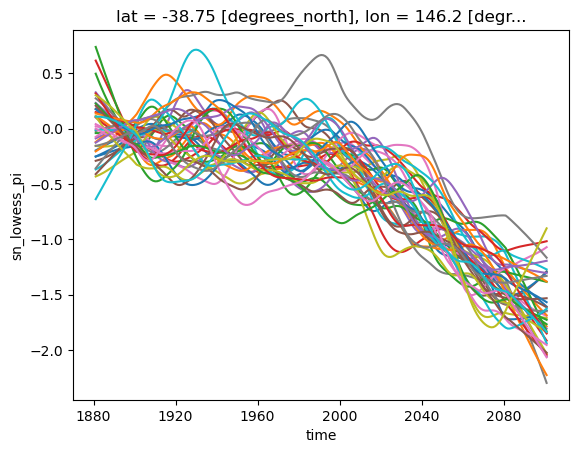

In [215]:
sn_lowess_pi.sel(lat=-39, lon=145, method='nearest').plot(**plot_kwargs);

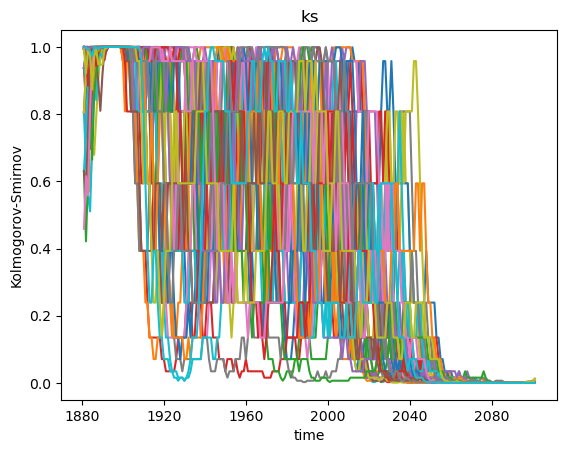

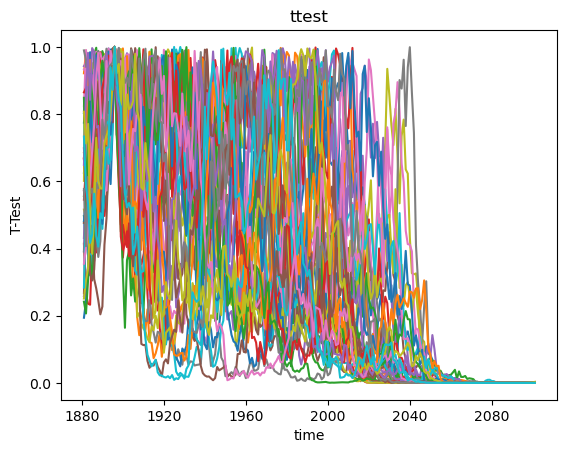

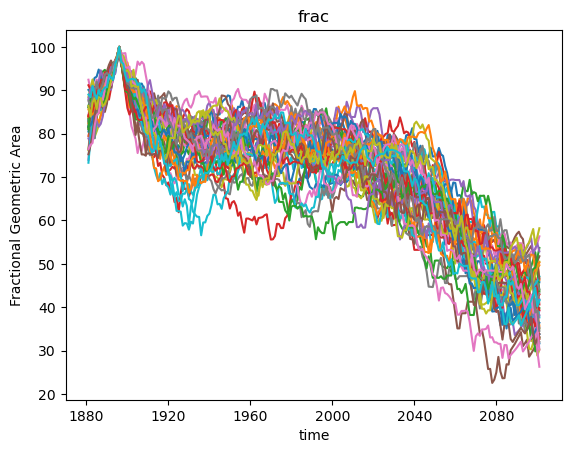

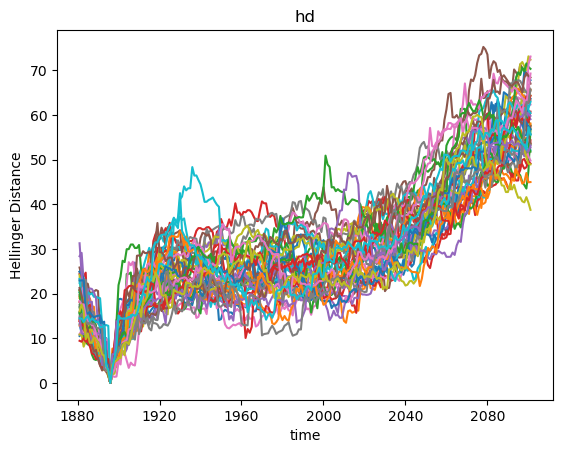

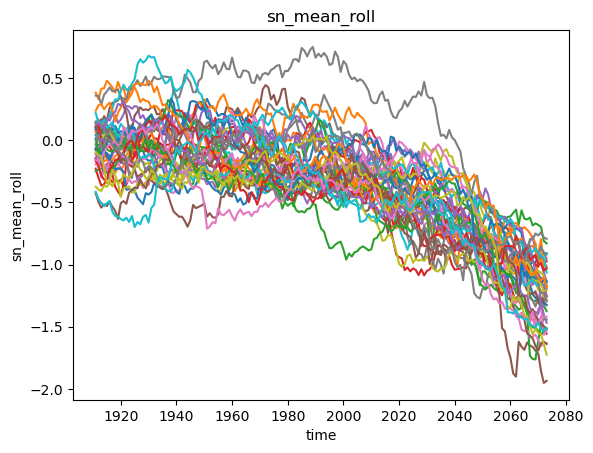

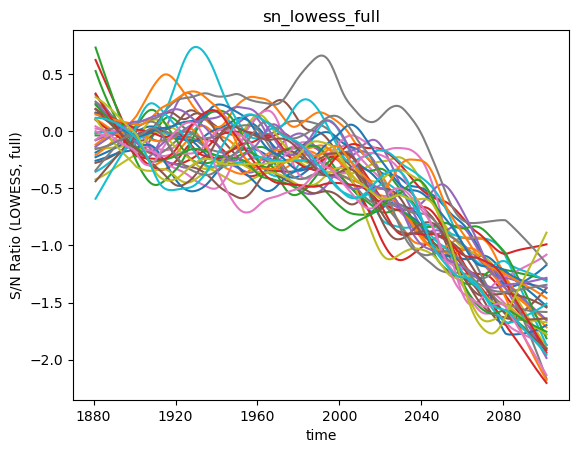

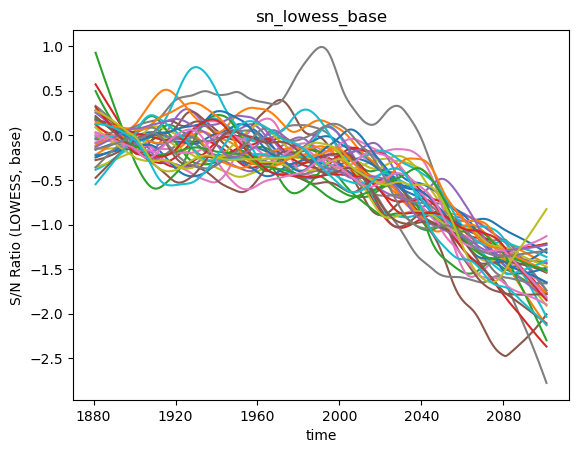

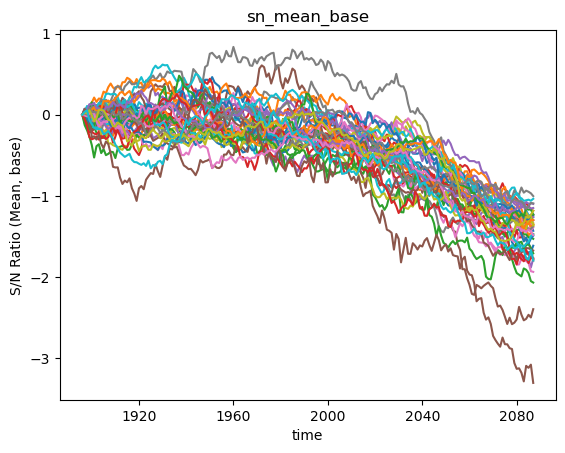

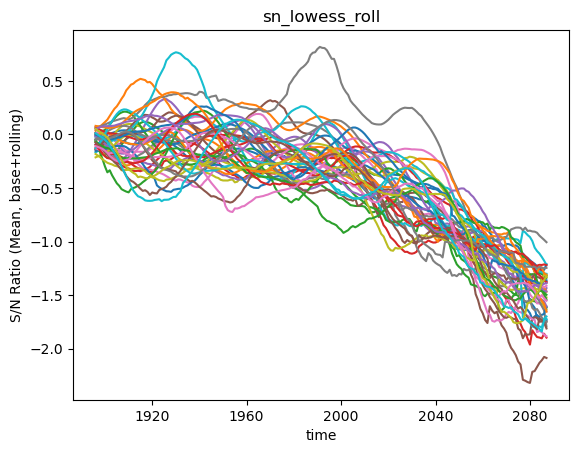

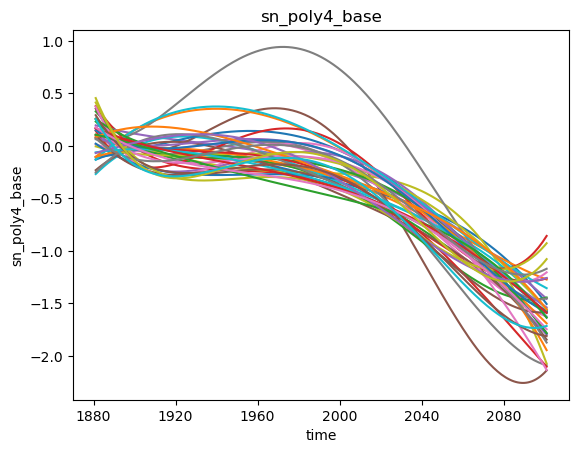

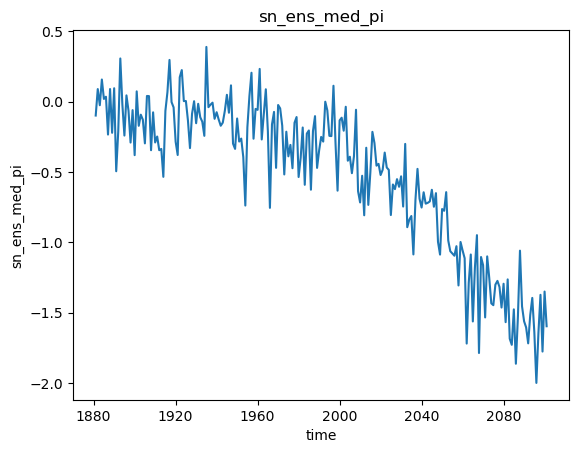

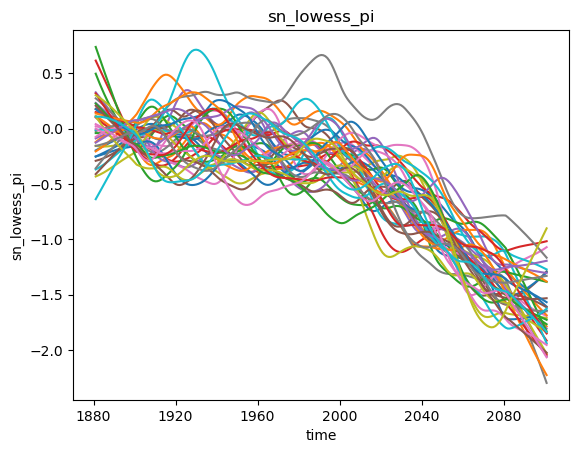

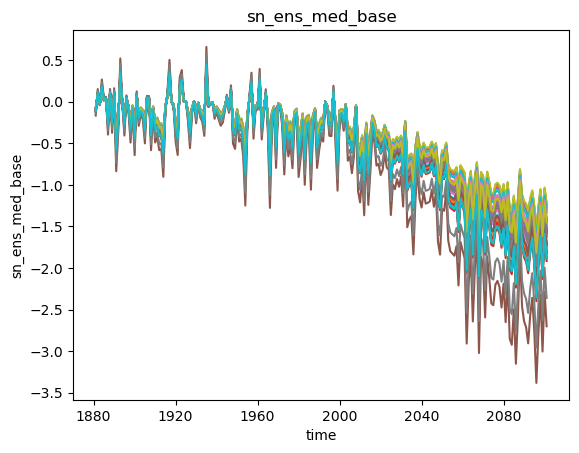

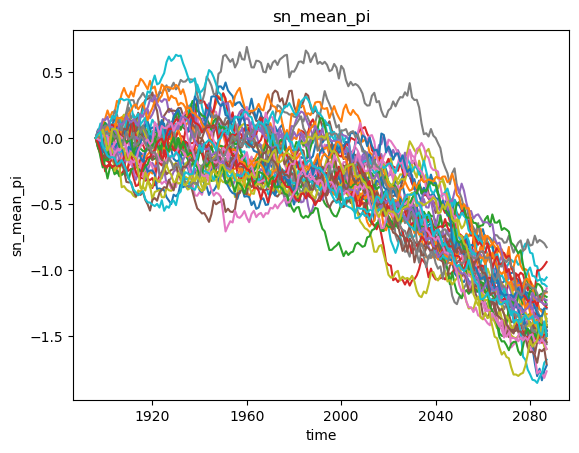

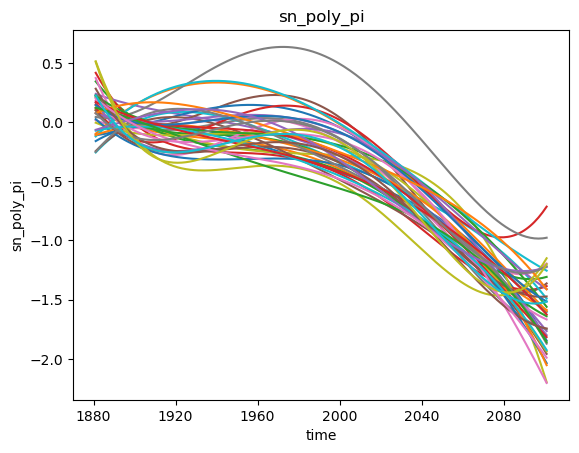

In [216]:
for var in toe_metrics_ds:
    toe_metrics_da = toe_metrics_ds[var].sel(lat=-39, lon=145, method='nearest')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    toe_metrics_da.plot(ax=ax, **plot_kwargs)
    ax.set_title(var)

In [217]:
dataset_name, variable, base_period

('access_ssp585', 'pr', BasePeriod(start=1880, end=1909))

In [218]:
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)'

In [219]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'data.zarr')
print(DATA_SAVE_NAME)
data_anom_ds.to_zarr(DATA_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)/data.zarr


In [220]:
signal_list = [
    ds_signal_lowess, ds_noise_series_lowess,
    ds_signal_mean, rolling_noise_lowess_ds, rolling_noise_mean_ds,
    signal_pol4_da, ds_noise_series_poly4
]

if 'member' in list(ds_signal_lowess.coords):
    print('Member in coords')

    signal_list = signal_list + [singal_ens_median, ds_noise_series_ens_median]

Member in coords


In [221]:
# THe signal is actually needed for lots of plots
singal_ds = xr.merge(signal_list) 
singal_ds

<xarray.Dataset> Size: 6GB
Dimensions:               (lat: 72, lon: 144, member: 40, time: 221)
Coordinates:
  * lat                   (lat) float64 576B -88.75 -86.25 ... 86.25 88.75
  * lon                   (lon) float64 1kB 1.25 3.75 6.25 ... 353.8 356.2 358.8
  * member                (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r9i1p1'
  * time                  (time) datetime64[ns] 2kB 1880-12-31 ... 2100-12-31
Data variables:
    signal_lowess         (member, lat, lon, time) float64 733MB -4.365 ... 2...
    noise_lowess          (member, lat, lon, time) float64 733MB -3.131 ... -...
    signal_mean           (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 6, 12, 220), meta=np.ndarray>
    noise_lowess_rolling  (member, lat, lon, time) float64 733MB nan nan ... nan
    noise_mean_rolling    (member, lat, lon, time) float64 733MB nan nan ... nan
    signal_poly4          (member, lat, lon, time) float64 733MB -0.7917 ... ...
    noise_poly4           (member, lat, lon, time) float64 733MB -6.704 ... -...
    signal_ens_med        (lat, lon, time) float64 18MB -0.6209 3.398 ... 218.1
    noise_ens_med         (member, lat, lon, time) float64 733MB -6.875 ... 0...

In [222]:
singal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

In [223]:
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')

In [224]:
data_availability_mask = data_availability_mask.chunk('auto')

In [225]:
print(DATA_AVAILABILITY_SAVE_NAME)
data_availability_mask.to_zarr(DATA_AVAILABILITY_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)/data_availability_mask.zarr


In [172]:
if 'le_pi_ds' in globals():
    print('Saving piControl')
    le_pi_ds.to_zarr(os.path.join(VAR_SAVE_DIR, f'piControl_{variable}.zarr'), mode='w')

Saving piControl


In [102]:
t_end = time()
time_taken = (t_end - t_start)/60
print(f'{time_taken=}minutes')

time_taken=2.814968248208364minutes


## Intercept Saving

In [ ]:
assert 1 == 0

In [197]:
SIGNAL_SAVE_NAME

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)/signal.zarr'

In [198]:
TOE_METRICS_SAVE_NAME

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)/toe_metrics.zarr'

In [199]:
singal_ds = xr.open_dataset(SIGNAL_SAVE_NAME, engine='zarr')

In [200]:
singal_ds = xr.merge(
    [singal_ds,
     singal_ens_median, ds_noise_series_ens_median, signal_pol4_da, ds_noise_series_poly4])

In [201]:
singal_ds

<xarray.Dataset> Size: 6GB
Dimensions:               (lat: 72, lon: 144, member: 40, time: 221)
Coordinates:
  * lat                   (lat) float64 576B -88.75 -86.25 ... 86.25 88.75
  * lon                   (lon) float64 1kB 1.25 3.75 6.25 ... 353.8 356.2 358.8
  * member                (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r9i1p1'
  * time                  (time) datetime64[ns] 2kB 1880-12-31 ... 2100-12-31
Data variables:
    noise_ens_med         (member, lat, lon, time) float64 733MB -6.875 ... 0...
    noise_lowess          (member, lat, lon, time) float64 733MB ...
    noise_lowess_rolling  (member, lat, lon, time) float64 733MB ...
    noise_mean_rolling    (member, lat, lon, time) float64 733MB ...
    noise_poly4           (member, lat, lon, time) float64 733MB -6.704 ... -...
    signal_ens_med        (lat, lon, time) float64 18MB -0.6209 3.398 ... 218.1
    signal_lowess         (member, lat, lon, time) float64 733MB ...
    signal_mean           (member, lat, lon, time) float64 733MB ...
    signal_poly4          (member, lat, lon, time) float64 733MB -0.7917 ... ...

In [202]:
singal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

In [203]:
toe_metrics_ds = xr.open_dataset(TOE_METRICS_SAVE_NAME, engine='zarr')

In [204]:
toe_metrics_ds

<xarray.Dataset> Size: 10GB
Dimensions:          (member: 40, lat: 72, lon: 144, time: 221)
Coordinates:
  * lat              (lat) float64 576B -88.75 -86.25 -83.75 ... 86.25 88.75
  * lon              (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member           (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time             (time) datetime64[ns] 2kB 1880-12-31 ... 2100-12-31
Data variables: (12/15)
    frac             (member, lat, lon, time) float64 733MB ...
    hd               (member, lat, lon, time) float64 733MB ...
    ks               (member, lat, lon, time) float64 733MB ...
    sn_ens_med_base  (lat, lon, time, member) float64 733MB ...
    sn_ens_med_pi    (lat, lon, time) float64 18MB ...
    sn_lowess_base   (member, lat, lon, time) float64 733MB ...
    ...               ...
    sn_mean_base     (member, lat, lon, time) float64 733MB ...
    sn_mean_pi       (member, lat, lon, time) float64 733MB ...
    sn_mean_roll     (member, lat, lon, time) float64 733MB ...
    sn_poly4_base    (member, lat, lon, time) float64 733MB ...
    sn_poly_pi       (member, lat, lon, time) float64 733MB ...
    ttest            (member, lat, lon, time) float64 733MB ...
Attributes: (1)

In [205]:
toe_metrics_ds = xr.merge(
    [toe_metrics_ds,
     sn_ens_med_pi, sn_lowess_pi, sn_poly4_base_ds, sn_lowess_roll, sn_ens_med_base_period, sn_mean_base, sn_mean_pi,
    sn_pol4_pi_ds
    ])

MergeError: conflicting values for variable 'pr' on objects to be combined. You can skip this check by specifying compat='override'.

In [ ]:
toe_metrics_ds

In [ ]:
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')

# Old

##### Old

In [ ]:
PI_CHUNKS = {'time':-1, 'lat':'auto', 'lon':'auto'}

In [ ]:
le_pi_ds = xr.open_mfdataset(os.path.join(PICONTROL_PATH, '*.nc'),
                             use_cftime=True).chunk(PI_CHUNKS).persist()

In [ ]:
le_pi_ds = le_pi_ds['pr']

In [ ]:
le_pi_ds.sel(lat=-39, lon=145, method='nearest').plot()

In [ ]:
data_ds

In [ ]:
le_pi_ds

In [ ]:
target_grid = data_ds.isel(time=0, member=0).drop_vars(['time', 'member']).compute()
target_grid

In [ ]:
climtas.regrid.cdo_generate_weights

In [ ]:
weights = climtas.regrid.cdo_generate_weights(le_pi_ds, target_grid, method='con')

In [ ]:
regridder = climtas.regrid.Regridder(weights = weights)

In [ ]:
le_pi_ds = regridder.regrid(le_pi_ds).persist()
wait(le_pi_ds);

In [ ]:
# target_grid = data_ds.isel(time=0).squeeze().drop_vars('time')

In [ ]:
# regridder = climtas.regrid.Regridder(le_pi_ds, target_grid, method='conservative')

In [ ]:
# le_pi_ds = regridder.regrid(le_pi_ds)

In [ ]:
# le_pi_ds = le_pi_ds.compute()

In [ ]:
le_pi_ds.isel(time=100).plot()

In [ ]:
# le_pi_ds.to_zarr(
#     f'/g/data/w40/ab2313/time_of_emergence/access_picontrol_{variable}.zarr', mode='w')
# wait(le_pi_ds);

In [ ]:
le_pi_ds_noise = le_pi_ds.std(dim='time').compute()

In [ ]:
singal_ens_median = data_anom_ds.median(dim='member')

In [ ]:
sn_pi = (ds_signal_lowess/le_pi_ds_noise).persist()
sn_ens_med = (singal_ens_median/le_pi_ds_noise).persist()
wait(sn_ens_med);

In [ ]:
sn_pi.name = 'sn_pi'
sn_ens_med.name = 'sn_ens_med'

In [ ]:
data_anom_ds.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);
singal_ens_median.sel(lat=-39, lon=145, method='nearest').plot(color='k');

In [ ]:
sn_pi.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);
sn_ens_med.sel(lat=-39, lon=145, method='nearest').plot(color='k');

### Perkins

In [ ]:
data_arr = data_ds.values.flatten()
data_arr.shape
# #data_arr = data_arr[data_arr != 0]

In [ ]:
bins = toe_calc.calculate_freedman_diaconis_bins(
    data_arr, length=len(data_ds.time.values), logginglevel='DEBUG')

np.unique(np.diff(bins).round(6)).item(), bins

In [ ]:
# bins = np.arange(bins[0], bins[-1]+0.5, 0.5) # For temperature
bins = np.arange(bins[0], bins[-1]+100, 100) # For precip

In [ ]:
bins

In [ ]:
# dmin = data_ds.min().values.item()
# dmax = data_ds.max().values.item()
# dmin, dmax

In [ ]:
# bins = np.arange(dmin, dmax+1, 1)

In [ ]:
# np.min(bins), np.max(bins)

In [ ]:
# Example latitudes and longitudes range (adjust as needed)
lats = np.linspace(-38.5, -37.5, 3)  # Replace with your actual latitudes
lons = np.linspace(144.5, 146.5, 3)  # Replace with your actual longitudes

# Create a 3x3 plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through latitudes and longitudes
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        # Extract the data for the current lat, lon
        test_data = data_ds.sel(lat=lat, lon=lon, method='nearest').values
        
        # Compute the KDE
        _, rel_freq = toe_calc.discrete_pdf(test_data, bins=bins)
        x_test, kde_test = toe_calc.create_kde(test_data, **kde_kwargs)

        # Plot on the current subplot
        ax = axs[i, j]
        ax2 = ax.twinx()
        ax.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
        ax2.plot(x_test, kde_test, color='r')
        ax.set_title(f'Lat: {lat}, Lon: {lon}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        valid_bins = bins[:-1][rel_freq > 0]
        x_min, x_max = valid_bins.min()-5*np.diff(bins)[0], valid_bins.max()+5*np.diff(bins)[0]
        ax.set_xlim(x_min, x_max)

In [ ]:
%%time
# Pre-calculate the relative frequency of the base period

base_period_rel_freq_ds = xr.apply_ufunc(
    toe_calc.get_rel_freq,
    base_period_ds,
    input_core_dims=[['time']],
    output_core_dims=[['bins']],
    kwargs={'bins': bins},
    vectorize=True,
    dask='parallelized',
    output_sizes={'bins': len(bins) - 1}, 
    output_dtypes=float
).persist()
wait(base_period_rel_freq_ds)

In [ ]:
%%time
perkins_ds = xr.apply_ufunc(
    toe_calc.perkins_skill_score_base_bins,
    data_ds_window,
    base_period_rel_freq_ds,
    kwargs={'bins': bins},
    input_core_dims=[['window_dim'], ['bins']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
    ).compute()

In [ ]:
perkins_ds = perkins_ds.sortby('lat')

In [ ]:
perkins_ds.attrs = {
    'window': window,
    **perkins_ds.attrs,
    'bins': 
    {
        'start':bins.round(4)[0],
        'stop':bins.round(4)[-1],
        'step': np.unique(np.diff(bins)).round(4)[0]}
}

In [ ]:
location = dict(lat=69, lon=-165, method='nearest')

In [ ]:
perkins_ds.sel(**location).plot()

In [ ]:
base_arr = base_period_ds.isel(member_kwargs).sel(**location).values


future_arr = (data_ds.sel(**location)
              .isel(member_kwargs)
              .sel(time=slice(str(base_period.start), str(base_period.end)))
              .values)

rel_freq_base = toe_calc.rel_freq(base_arr, bins)
rel_freq_future = toe_calc.rel_freq(future_arr, bins=bins)

In [ ]:
toe_calc.discrete_distribution_overlap(rel_freq_base, rel_freq_future),\
toe_calc.perkins_skill_score(future_arr, base_arr, bins=bins),\
perkins_ds.sel(**location).isel(time=int(window/2), **member_kwargs).values.item()

In [ ]:
fig, ax = plt.subplots(1, 1)
diagnostic_tools.plot_bar(bins, rel_freq_base, ax=ax)
diagnostic_tools.plot_bar(bins, rel_freq_future, ax=ax)

In [ ]:
toe_calc.perkins_skill_score_base_bins(
    data_ds_window.isel(member_kwargs).sel(lat=-39, lon=145,method='nearest').isel(time=slice(None, 31)).values,
    base_period_rel_freq_ds.isel(member_kwargs).sel(lat=-39, lon=145,method='nearest').values,
    bins=bins
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')
rel_freq_test = toe_calc.get_rel_freq(base_period_ds.sel(**test_loc).isel(**member_kwargs).squeeze().values, bins=bins)

ax1.bar(base_period_rel_freq_ds.bins.values, rel_freq_test)
ax2.bar(base_period_rel_freq_ds.bins.values, base_period_rel_freq_ds.sel(**test_loc).isel(**member_kwargs).values)

In [ ]:
perkins_ds.isel(time=int(window/2), **member_kwargs).plot();

In [ ]:
# These should all be 100
perkins_ds.sel(lat=[-80, 0, 60, 88], lon=145, method='nearest').isel(time=window//2).plot(hue='lat');

In [ ]:
perkins_ds.isel(time=[int(window/2), 35, 50], **member_kwargs).plot(col='time', levels=np.arange(0, 110, 5))